# Experiment # 3. - TRIMAP as pre- and post-processing step.

**Semi-Supervised Learning with TRIMAP**:
- Apply Uniform Manifold Approximation and Projection (TRIMAP) for DR on node features before and after training a semi-supervised GNN model.
- Evaluate the model on a more complex dataset like Citeseer, focusing on the impact of DR on label propagation and the learning of node representations.

Import section:

In [1]:
!pip install torch_geometric trimap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552450 sha256=a219f843fd89af9d372998b7d76a515005eaa7a717f22d6d5ccc5c779dddc22f
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [2]:
import torch
from torch_geometric.nn import GCNConv, BatchNorm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Define a simple GCN model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


class GCN_with_dropout(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(GCN_with_dropout, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)



class GCN_with_dropout_and_bn(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate=0.5):
        super(GCN_with_dropout_and_bn, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)  # Batch normalization layer after conv1
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.bn2 = BatchNorm(output_dim)  # Batch normalization layer after conv2
        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Apply batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Apply batch normalization
        x = F.dropout(x, p=self.dropout_rate, training=self.training)  # Optional: Dropout before softmax

        return F.log_softmax(x, dim=1)

# # Define the GCN model
# class GCN(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(GCN, self).__init__()
#         self.conv1 = GCNConv(input_dim, hidden_dim)
#         self.conv2 = GCNConv(hidden_dim, output_dim)

#     def forward(self, x, edge_index):
#         x = F.relu(self.conv1(x, edge_index))
#         x = self.conv2(x, edge_index)
#         return x


def generate_train_test(data, split_ratio=0.8):
    # Define train and test masks
    num_nodes = data.num_nodes
    num_train = int(num_nodes * 0.8)  # For example, 80% for training

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    # Randomly select nodes for training and testing
    perm = torch.randperm(num_nodes)
    train_mask[perm[:num_train]] = True
    test_mask[perm[num_train:]] = True

    # Assign masks to data
    data.train_mask = train_mask
    data.test_mask = test_mask


def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def test(model, data):
    model.eval()
    logits, accs = model(data), []
    for mask in [data.train_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits.argmax(dim=1)
        labels = data.y

    # Calculate metrics only for the test set
    mask = data.test_mask
    test_preds = preds[mask].cpu().numpy()
    test_labels = labels[mask].cpu().numpy()

    accuracy = accuracy_score(test_labels, test_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='macro')

    return accuracy, precision, recall, f1



def train_loop(n_epochs, model, optimizer, data, acc_freq=5, verbose=False):
    # Initialize lists to store the metrics
    loss_history = []
    train_acc_history = []
    test_acc_history = []

    for epoch in range(200):
        loss = train(model, optimizer, data)
        loss_history.append(loss)

        # Optionally, calculate training accuracy every few epochs to save computation
        if epoch % acc_freq == 0 and acc_freq != -1:
            train_acc, test_acc = test(model, data)
            train_acc_history.append(train_acc)
            test_acc_history.append(test_acc)
            if verbose:
                print(f'Epoch {epoch+1}, Loss: {loss:.4f}, Training Accuracy: {train_acc:.4f}')

    return loss_history, train_acc_history, test_acc_history



def plot_training_history(loss_history, train_acc_history, test_acc_history, acc_freq=5, grid=False):
    # Plotting the loss history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss History')
    plt.legend()
    # if grid:
    plt.grid(grid)

    # Plotting the training accuracy history
    plt.subplot(1, 2, 2)
    epochs_acc = range(0, len(loss_history), int(len(loss_history)/len(train_acc_history)))
    plt.plot(epochs_acc, train_acc_history, label='Training Accuracy', color='orange')
    plt.plot(epochs_acc, test_acc_history, label='Test Accuracy', color='darkred')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy History')
    plt.legend()
    # if grid:
    plt.grid(grid)

    plt.tight_layout()
    plt.show()


def plot_no_show(ax, results, labels, title, size=None, sample=False):
    unique_labels = np.unique(labels)
    if sample:
        sample_fraction=0.3
    else:
        sample_fraction = None
    if sample_fraction is not None:
        # Determine the number of samples to take
        num_samples = int(len(results) * sample_fraction)
        # Create a random choice of indices based on the sample size
        sampled_indices = np.random.choice(len(results), num_samples, replace=False)
        # Subset results and labels
        results = results[sampled_indices]
        labels = labels[sampled_indices]

    # for label in unique_labels:
    #     indices = labels == label
    #     ax.scatter(results[indices, 0], results[indices, 1], label=str(label), alpha=0.1, s=size)
    color_dict = {0: u'#1f77b4', 1: u'#ff7f0e', 2: u'#2ca02c', 3: u'#d62728', 4: u'#9467bd', 5: u'#8c564b', 6: u'#e377c2', 7: u'#7f7f7f', 8: u'#bcbd22', 9: u'#17becf'}
    ax.scatter(results[:, 0], results[:, 1], c=[color_dict[label] for label in labels], alpha=0.5, s=size)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)


def visualise(results, labels, title, size=None, sample=False):
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_no_show(ax, results, labels, title, size, sample)
    plt.show()

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Coauthor
from torch_geometric.nn import GCNConv
from trimap import TRIMAP
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import warnings


random_state = 0
random.seed(0)
torch.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
warnings.filterwarnings('ignore', message="n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.")
warnings.filterwarnings('ignore', message="Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.")
warnings.filterwarnings('ignore', message="Graph is not fully connected, spectral embedding may not work as expected.")
print("Is cuda available?", torch.cuda.is_available())

Is cuda available? False


## 1. Training the model on original features

Loading the CiteSeer dataset:

In [4]:
dataset = Coauthor(root='.', name='Physics')
data = dataset[0].to(device) # Move data to GPU
generate_train_test(data)

# prepare variables for further TRIMAP experiments
data_x_cpu = dataset[0].x.cpu().detach().numpy()
data_y_cpu = dataset[0].y.cpu().numpy()

Processing...
Done!


Defining the GCN model and optimizer:

In [5]:
model = GCN(input_dim=dataset.num_node_features, hidden_dim=64, output_dim=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Training loop and model evaluation:

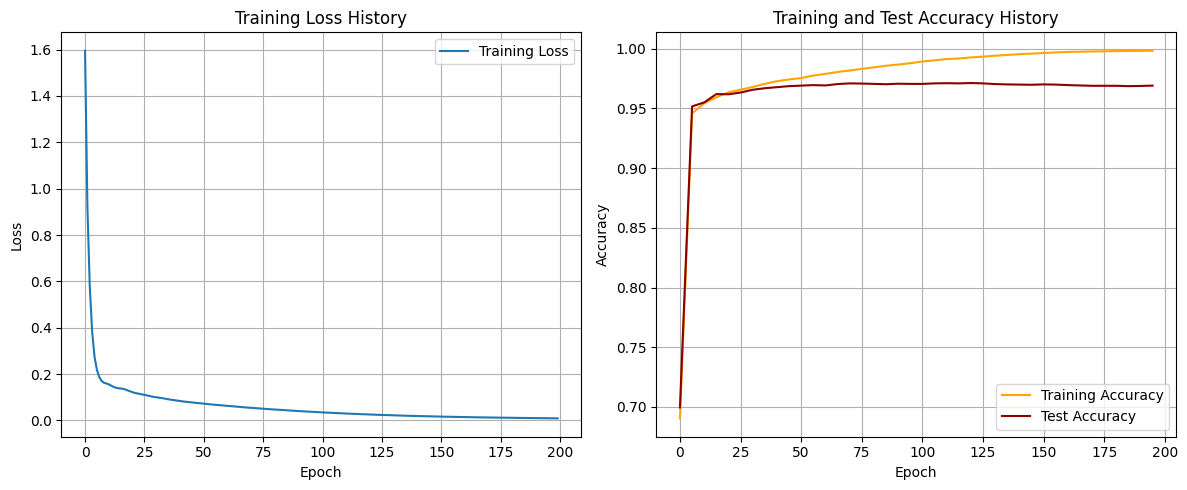

Accuracy: 0.9691, Precision: 0.9576, Recall: 0.9578, F1 Score: 0.9577


In [6]:
n_epochs = 200
loss_history, train_acc_history, test_acc_history = train_loop(n_epochs, model, optimizer, data)

plot_training_history(loss_history, train_acc_history, test_acc_history, grid=True)

accuracy, precision, recall, f1 = evaluate_model(model, data)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

## 2. TRIMAP as post-processing step
In this section the TRIMAP visualisation is prepared using the output of the model trained on original features.

In [7]:
model = GCN(input_dim=dataset.num_node_features, hidden_dim=64, output_dim=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_loop(200, model, optimizer, data)

# Extract node representations
model.eval()
with torch.no_grad():
    embeddings = model(data)

embeddings = embeddings.cpu().numpy()

### 2.1 Default TRIMAP

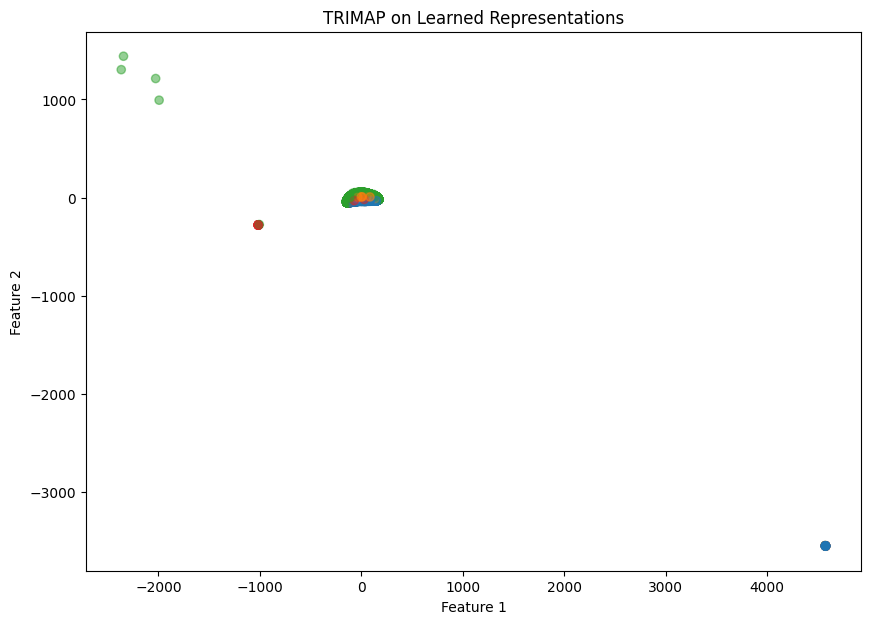

In [ ]:
# Apply TRIMAP on Learned Node Representations
umap_post = TRIMAP(n_dims=2)
embeddings_umap_post = umap_post.fit_transform(embeddings)

visualise(embeddings_umap_post, data_y_cpu, 'TRIMAP on Learned Representations')

### 2.2 Fine-tuning TRIMAP

#### 2.2.1 distance vs n_inliners vs n_outliers

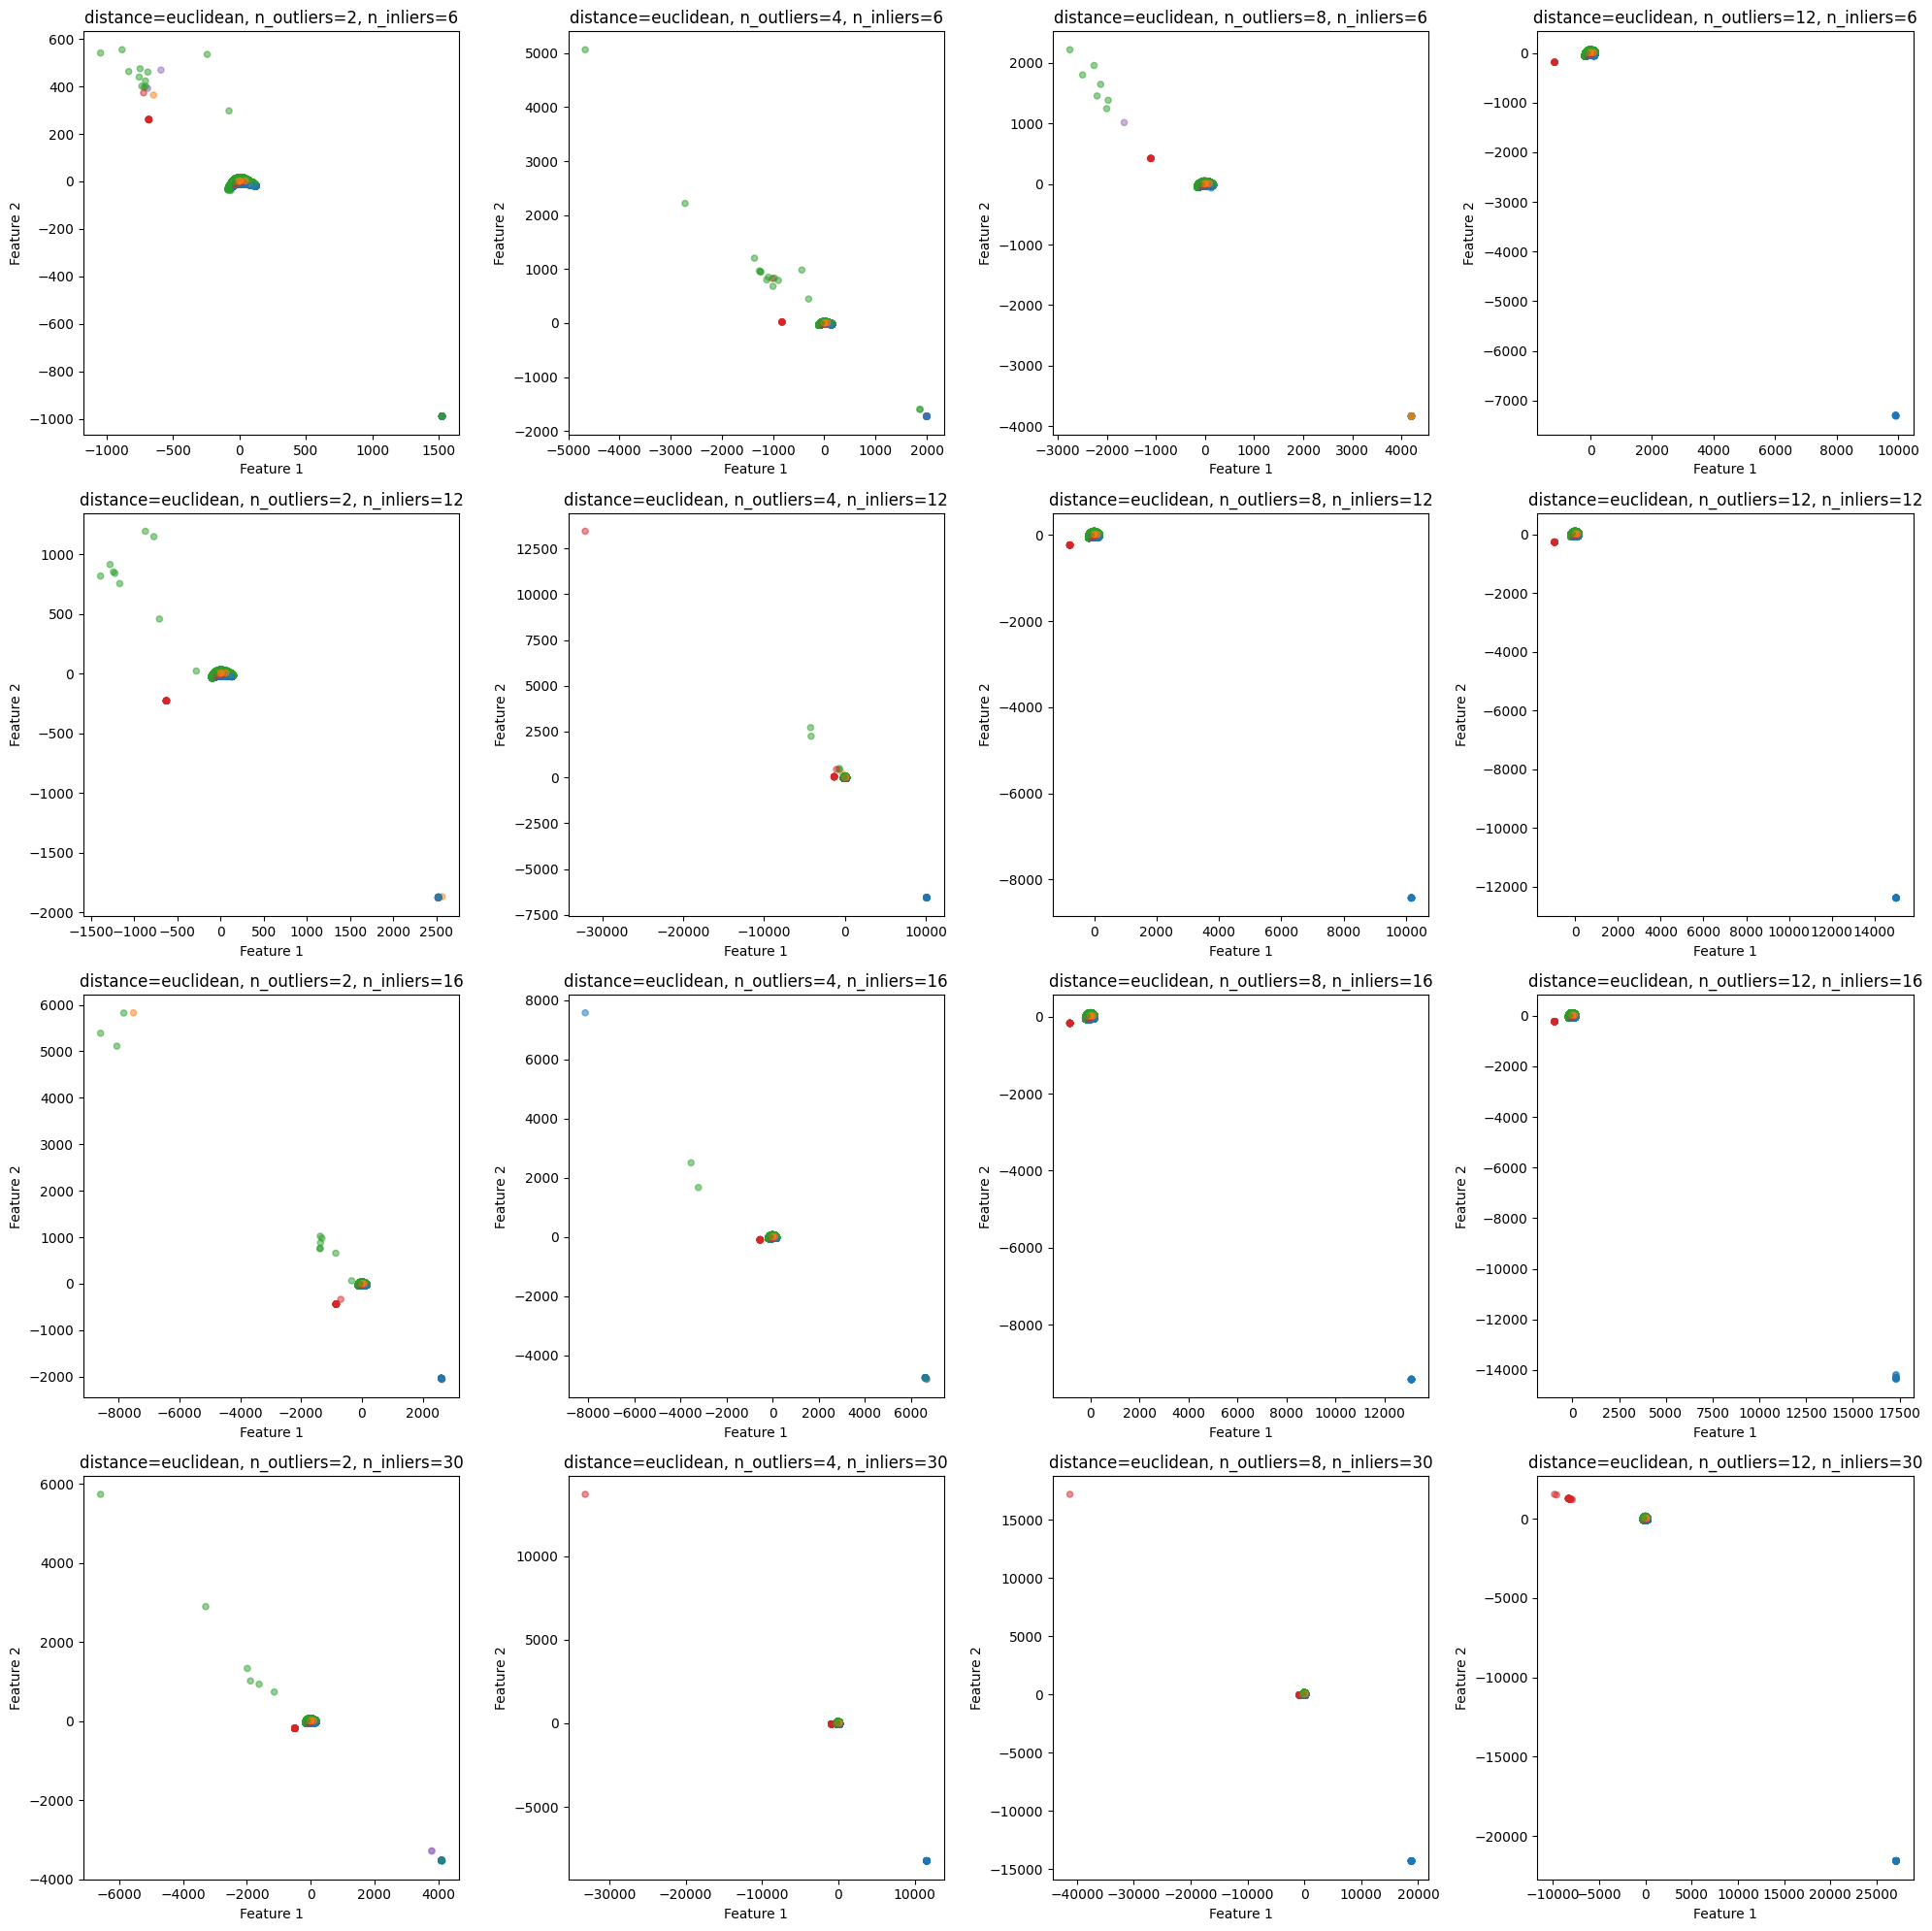

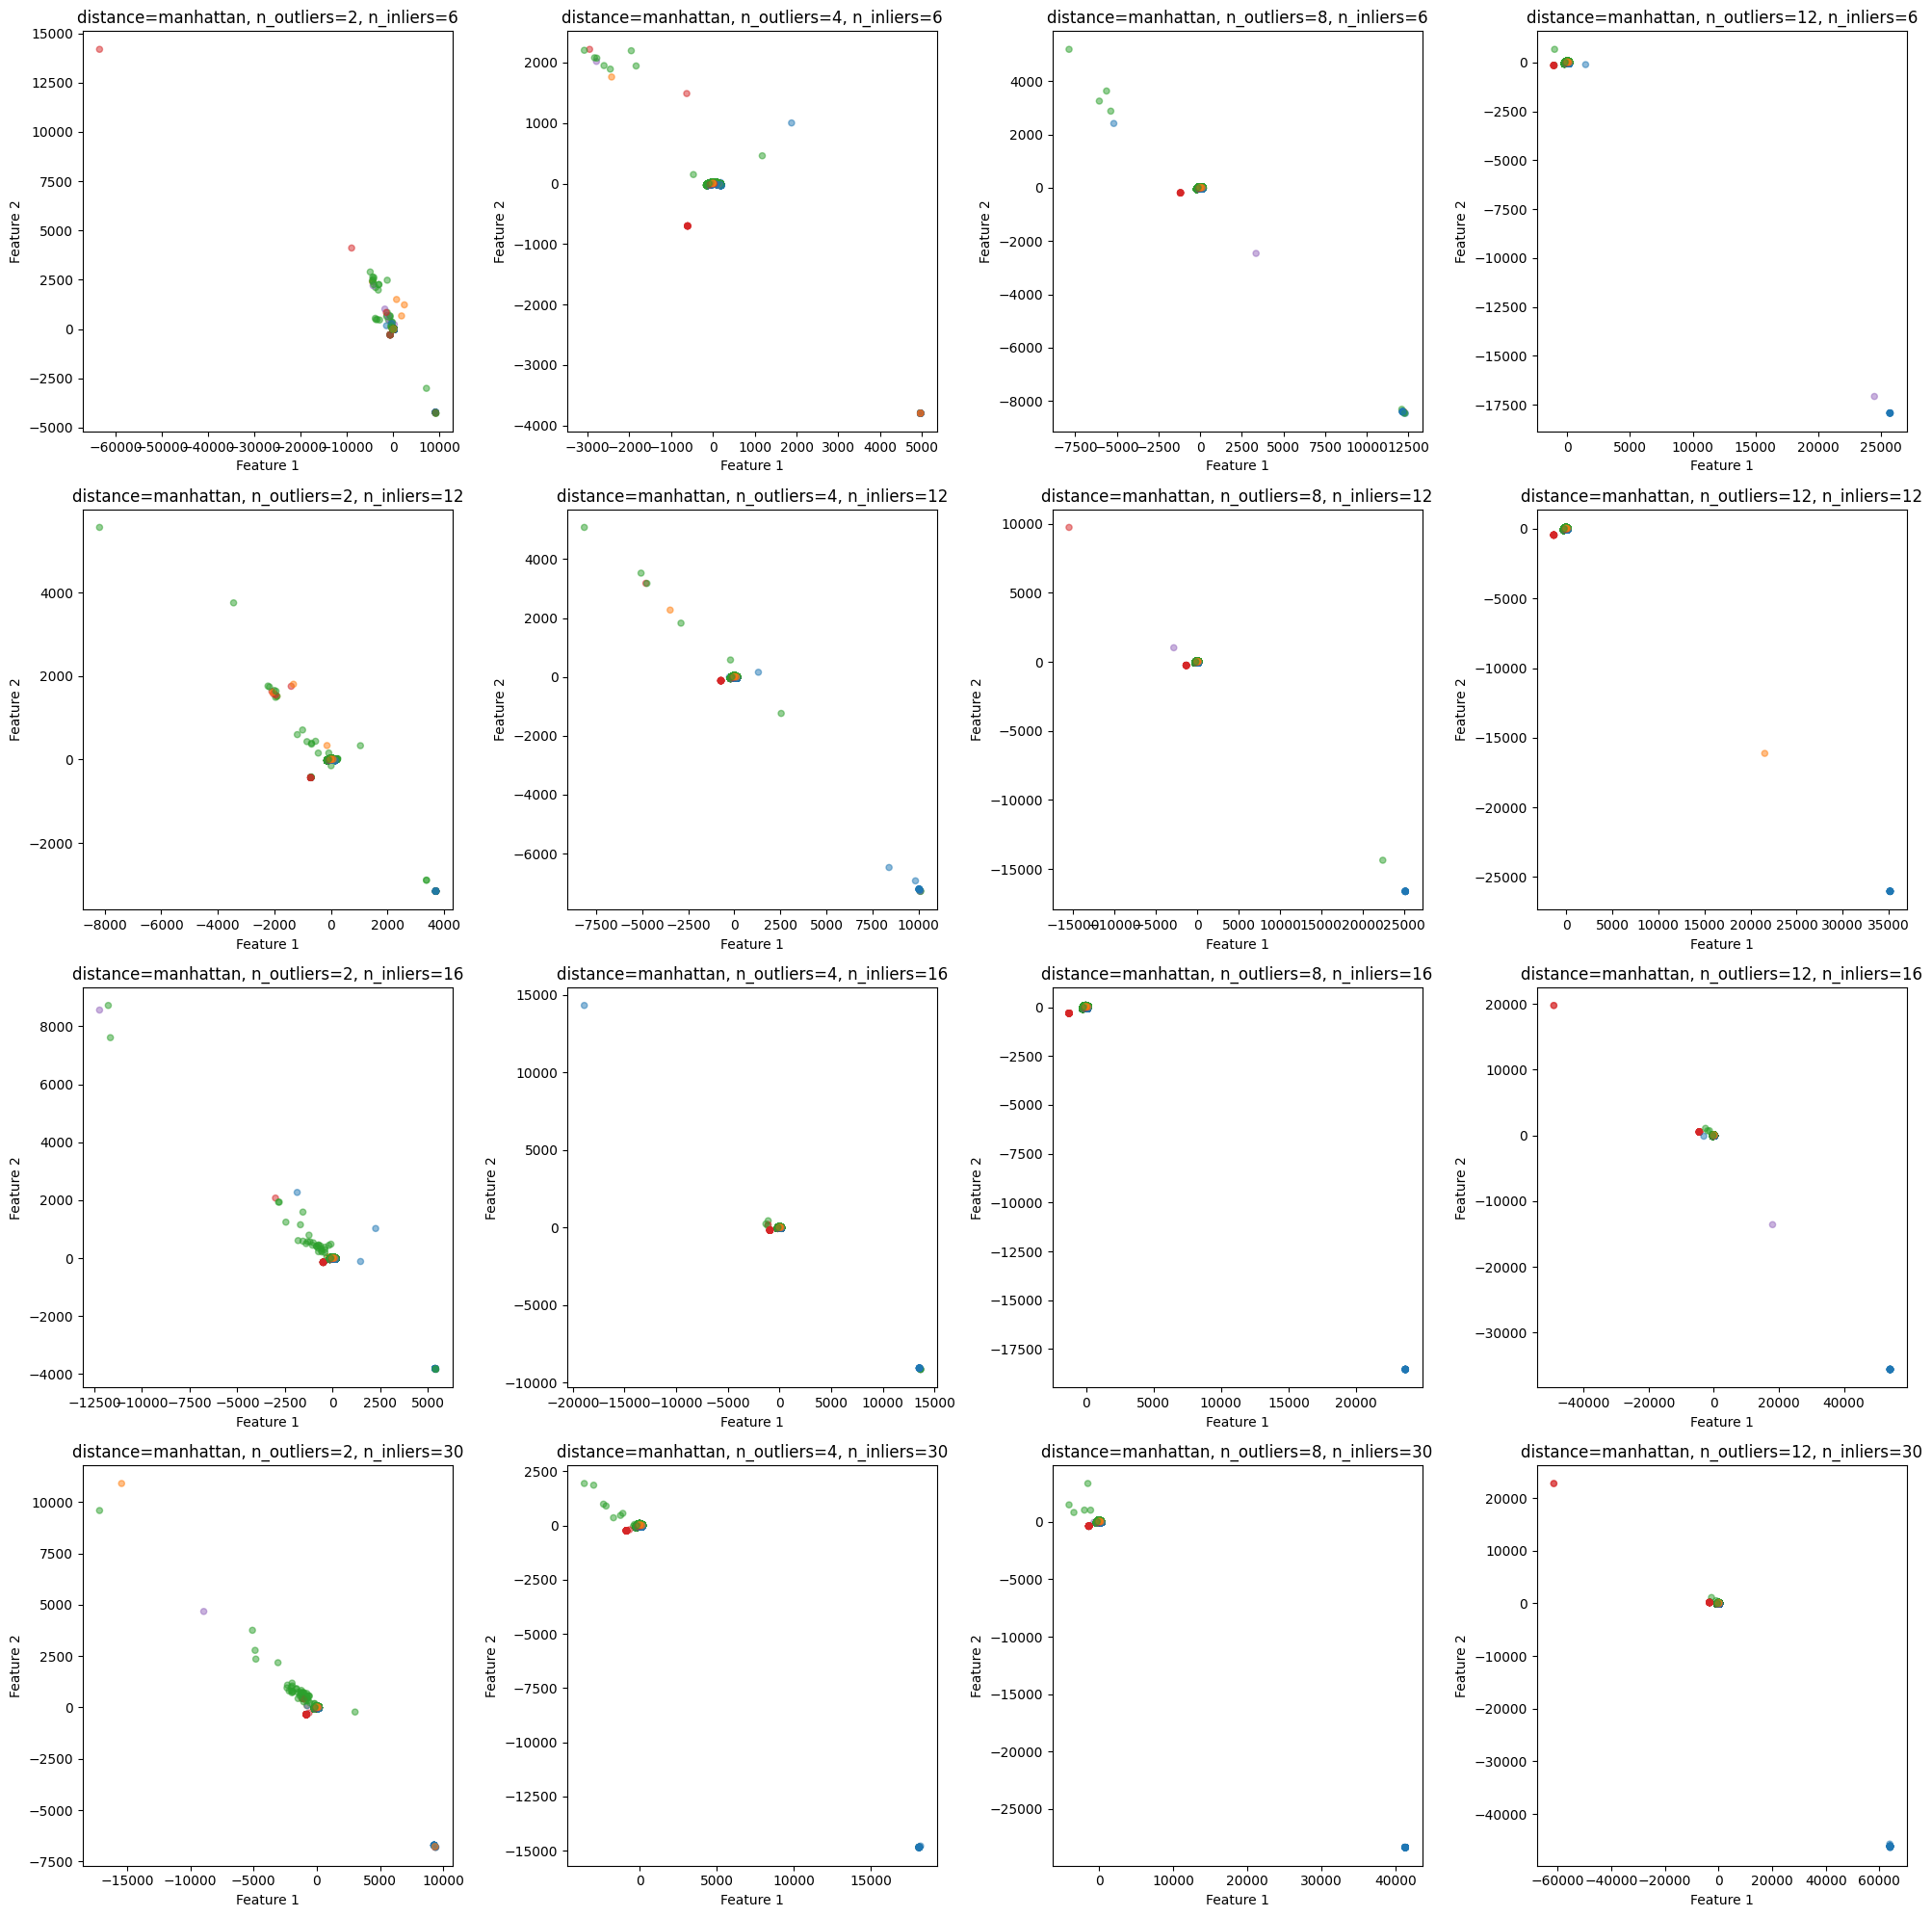

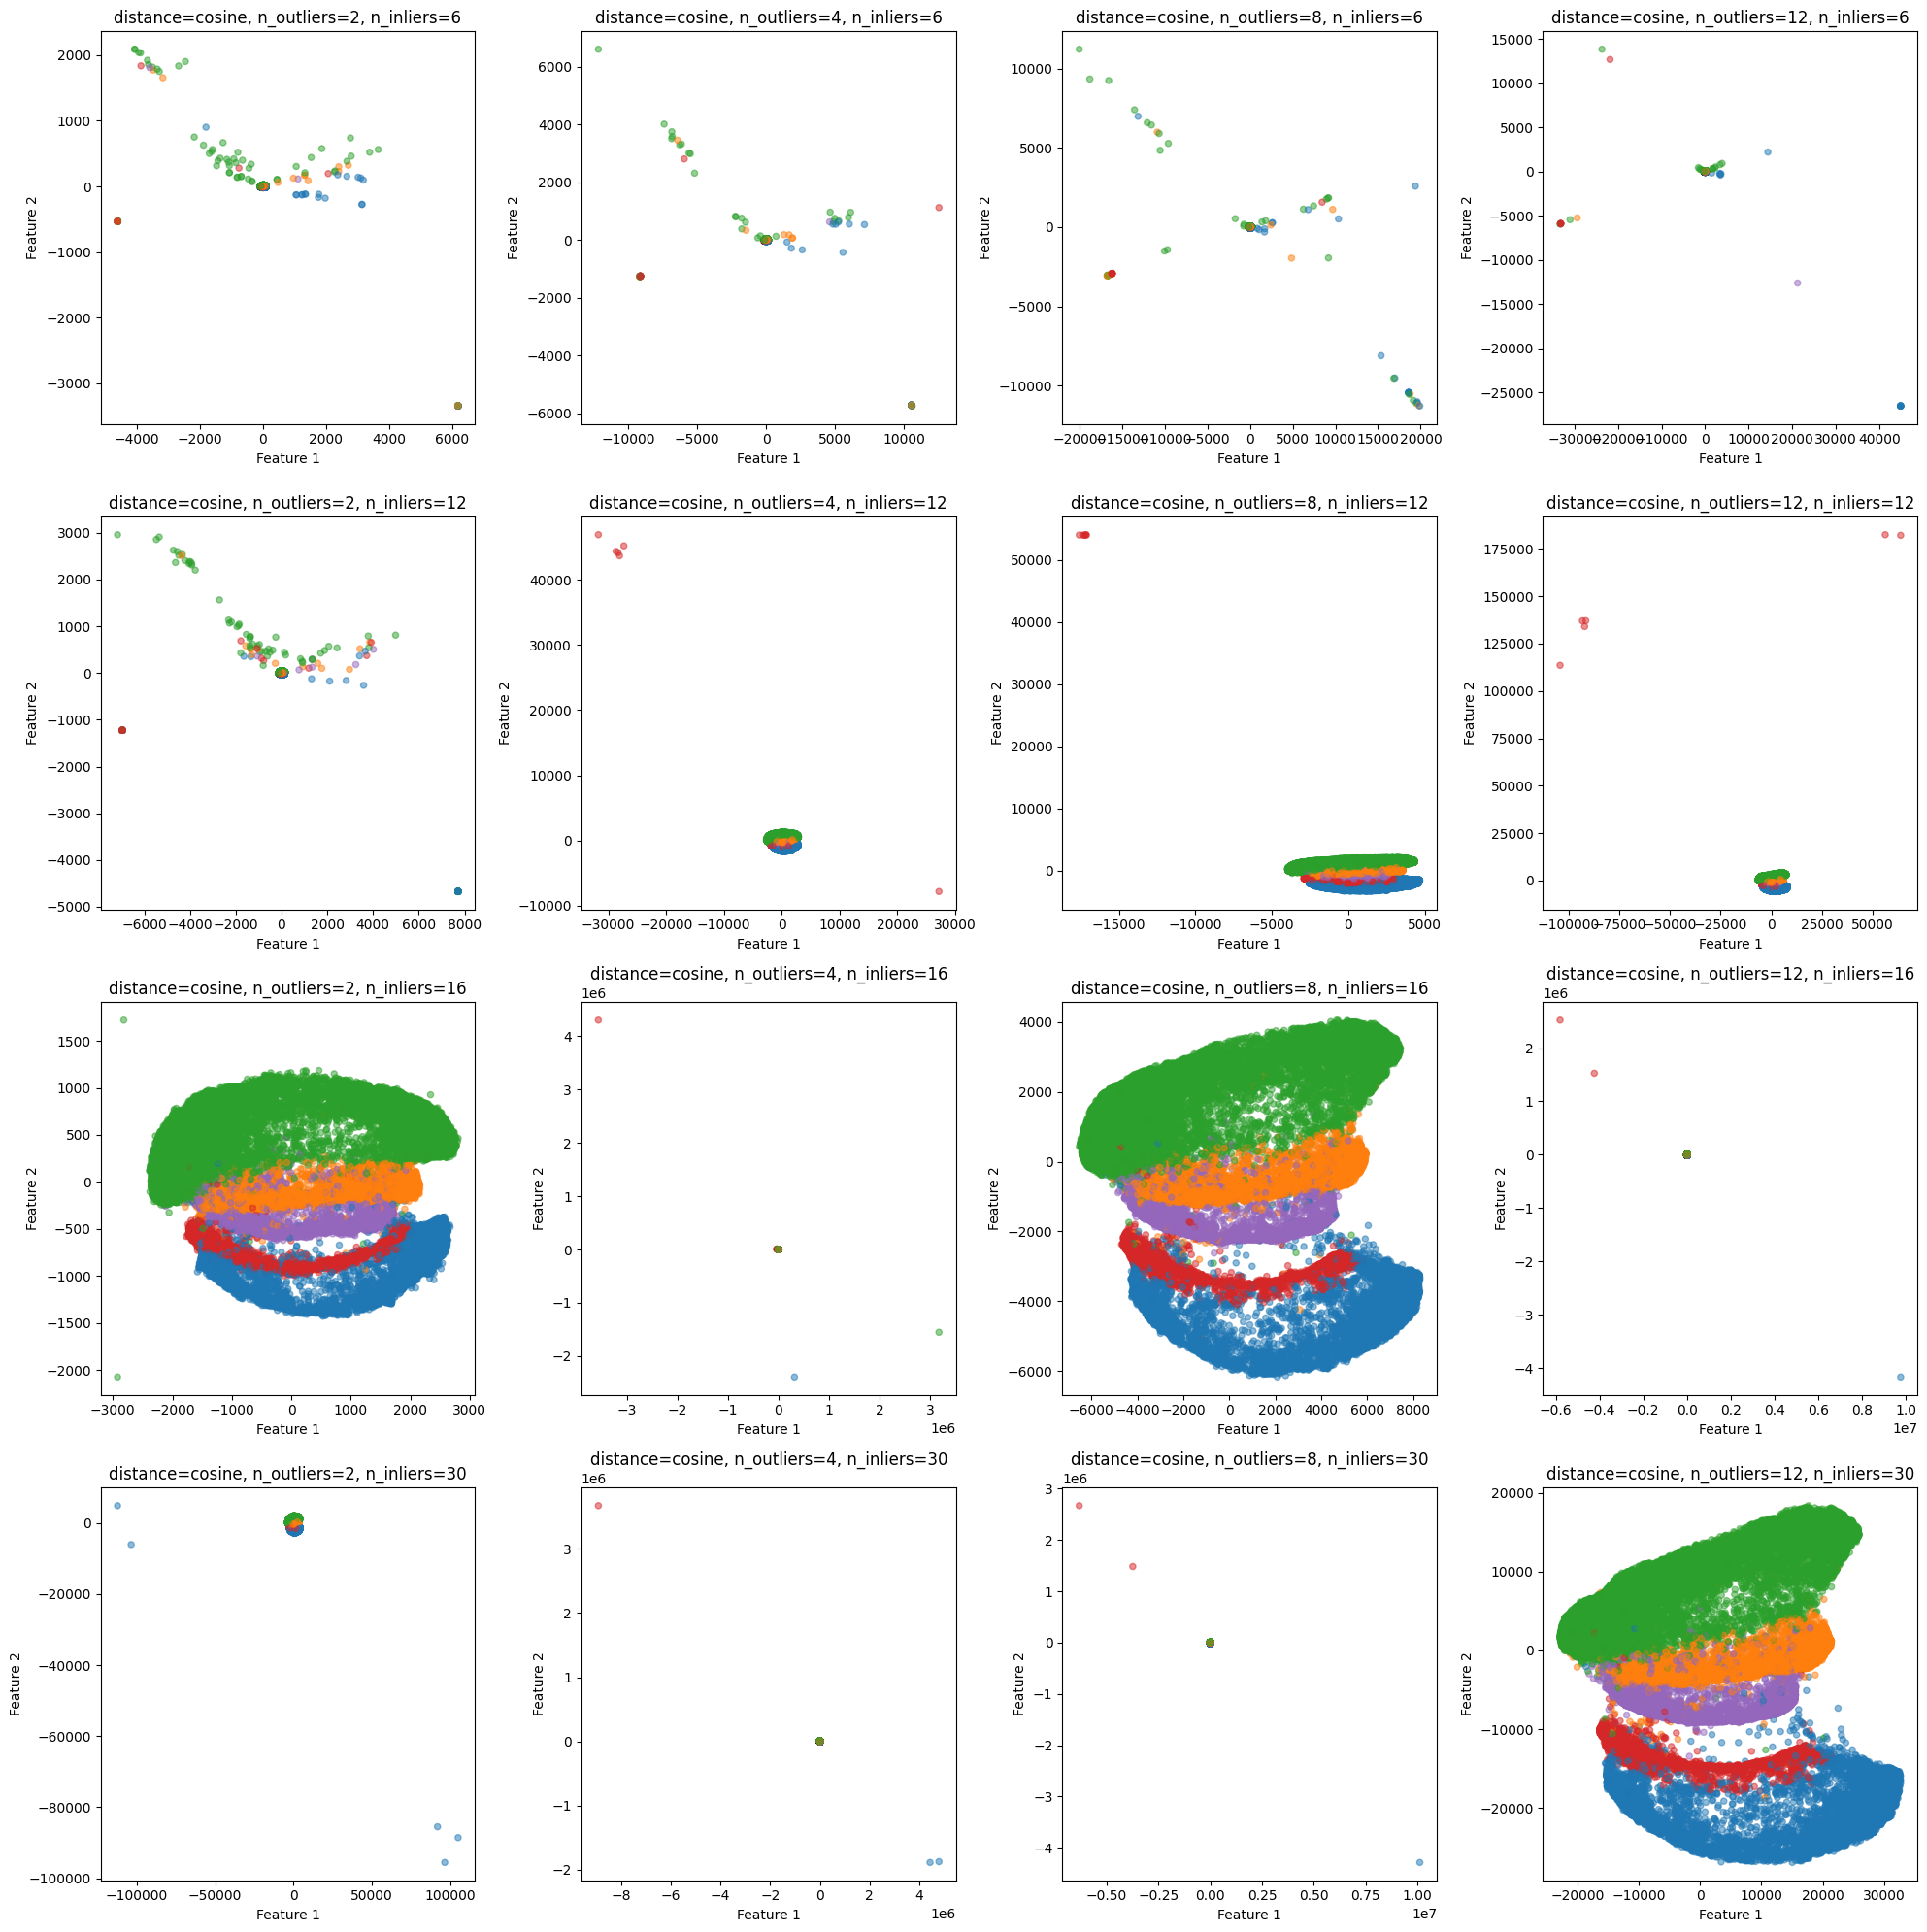

In [ ]:
for distance in ['euclidean', 'manhattan', 'cosine']:
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    axs = axs.flatten()
    i = 0
    for n_inliers in [6, 12, 16, 30]:
        for n_outliers in [2, 4, 8, 12]:
            umap_post = TRIMAP(n_dims=2 , n_outliers=n_outliers, n_inliers=n_inliers, distance=distance)
            umap_results = umap_post.fit_transform(embeddings)

            plot_no_show(axs[i], umap_results, data_y_cpu, f'distance={distance}, n_outliers={n_outliers}, n_inliers={n_inliers}', size=20)

            i += 1


    plt.tight_layout()
    plt.show()

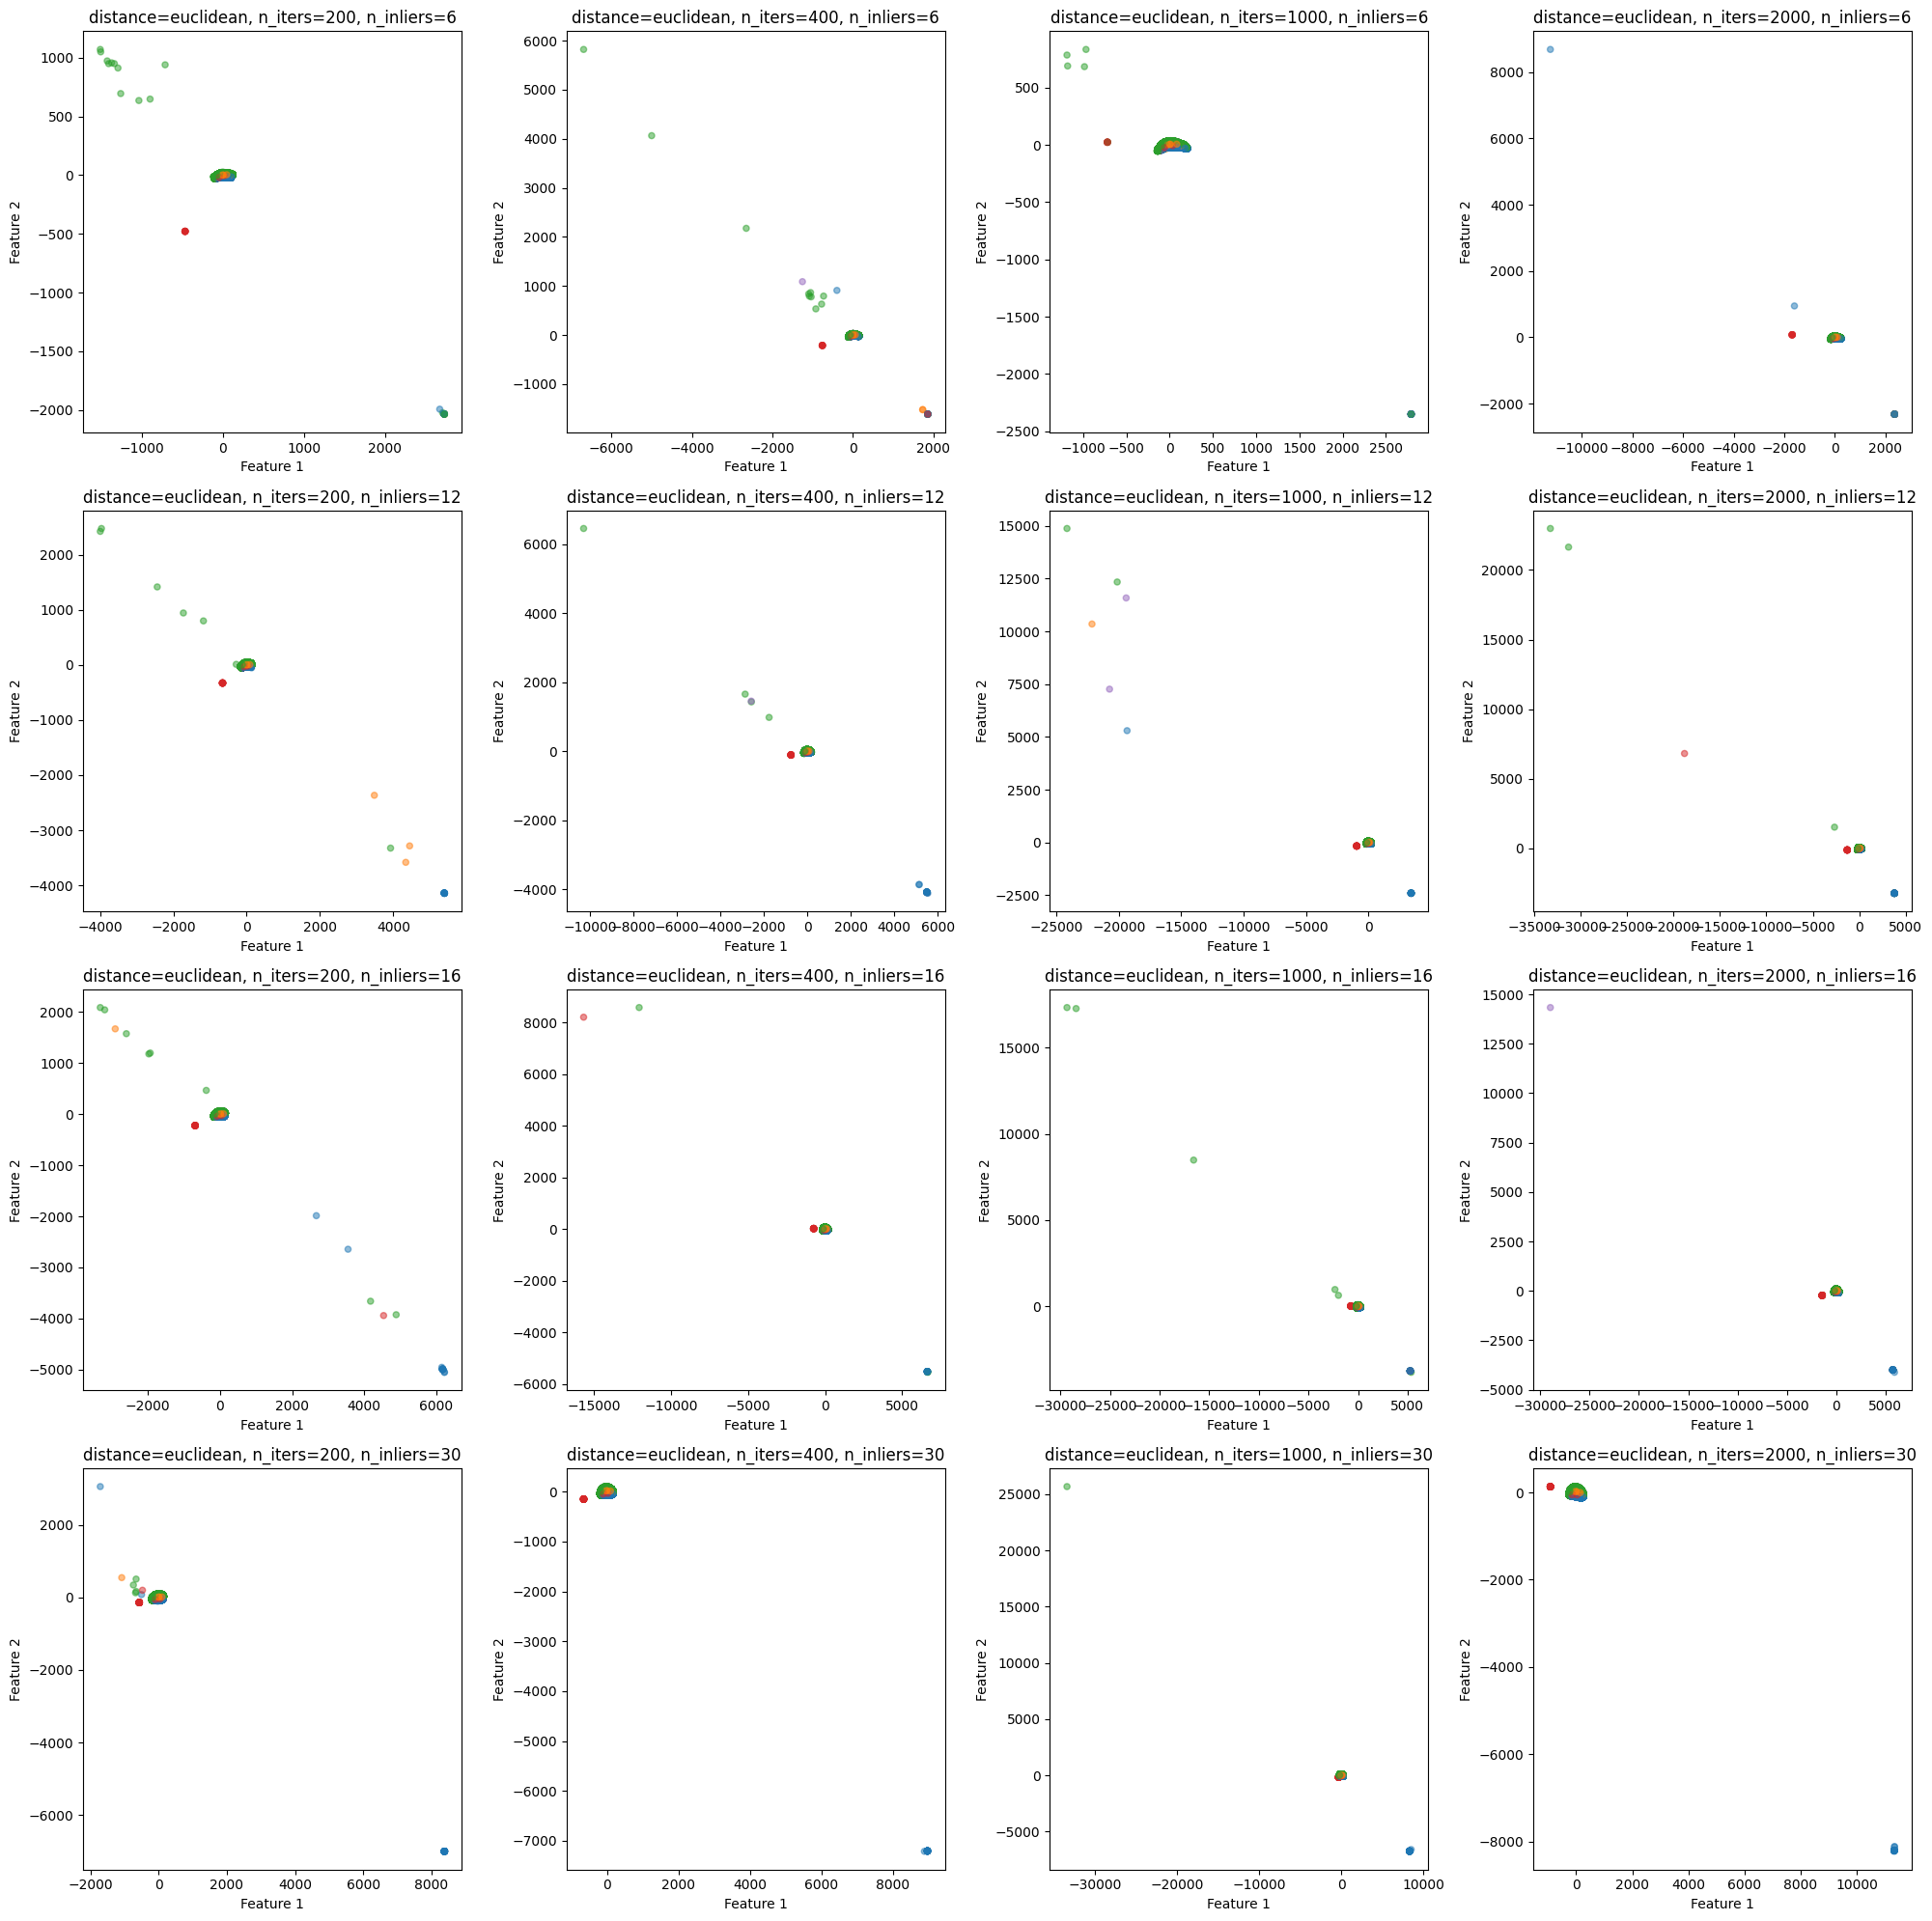

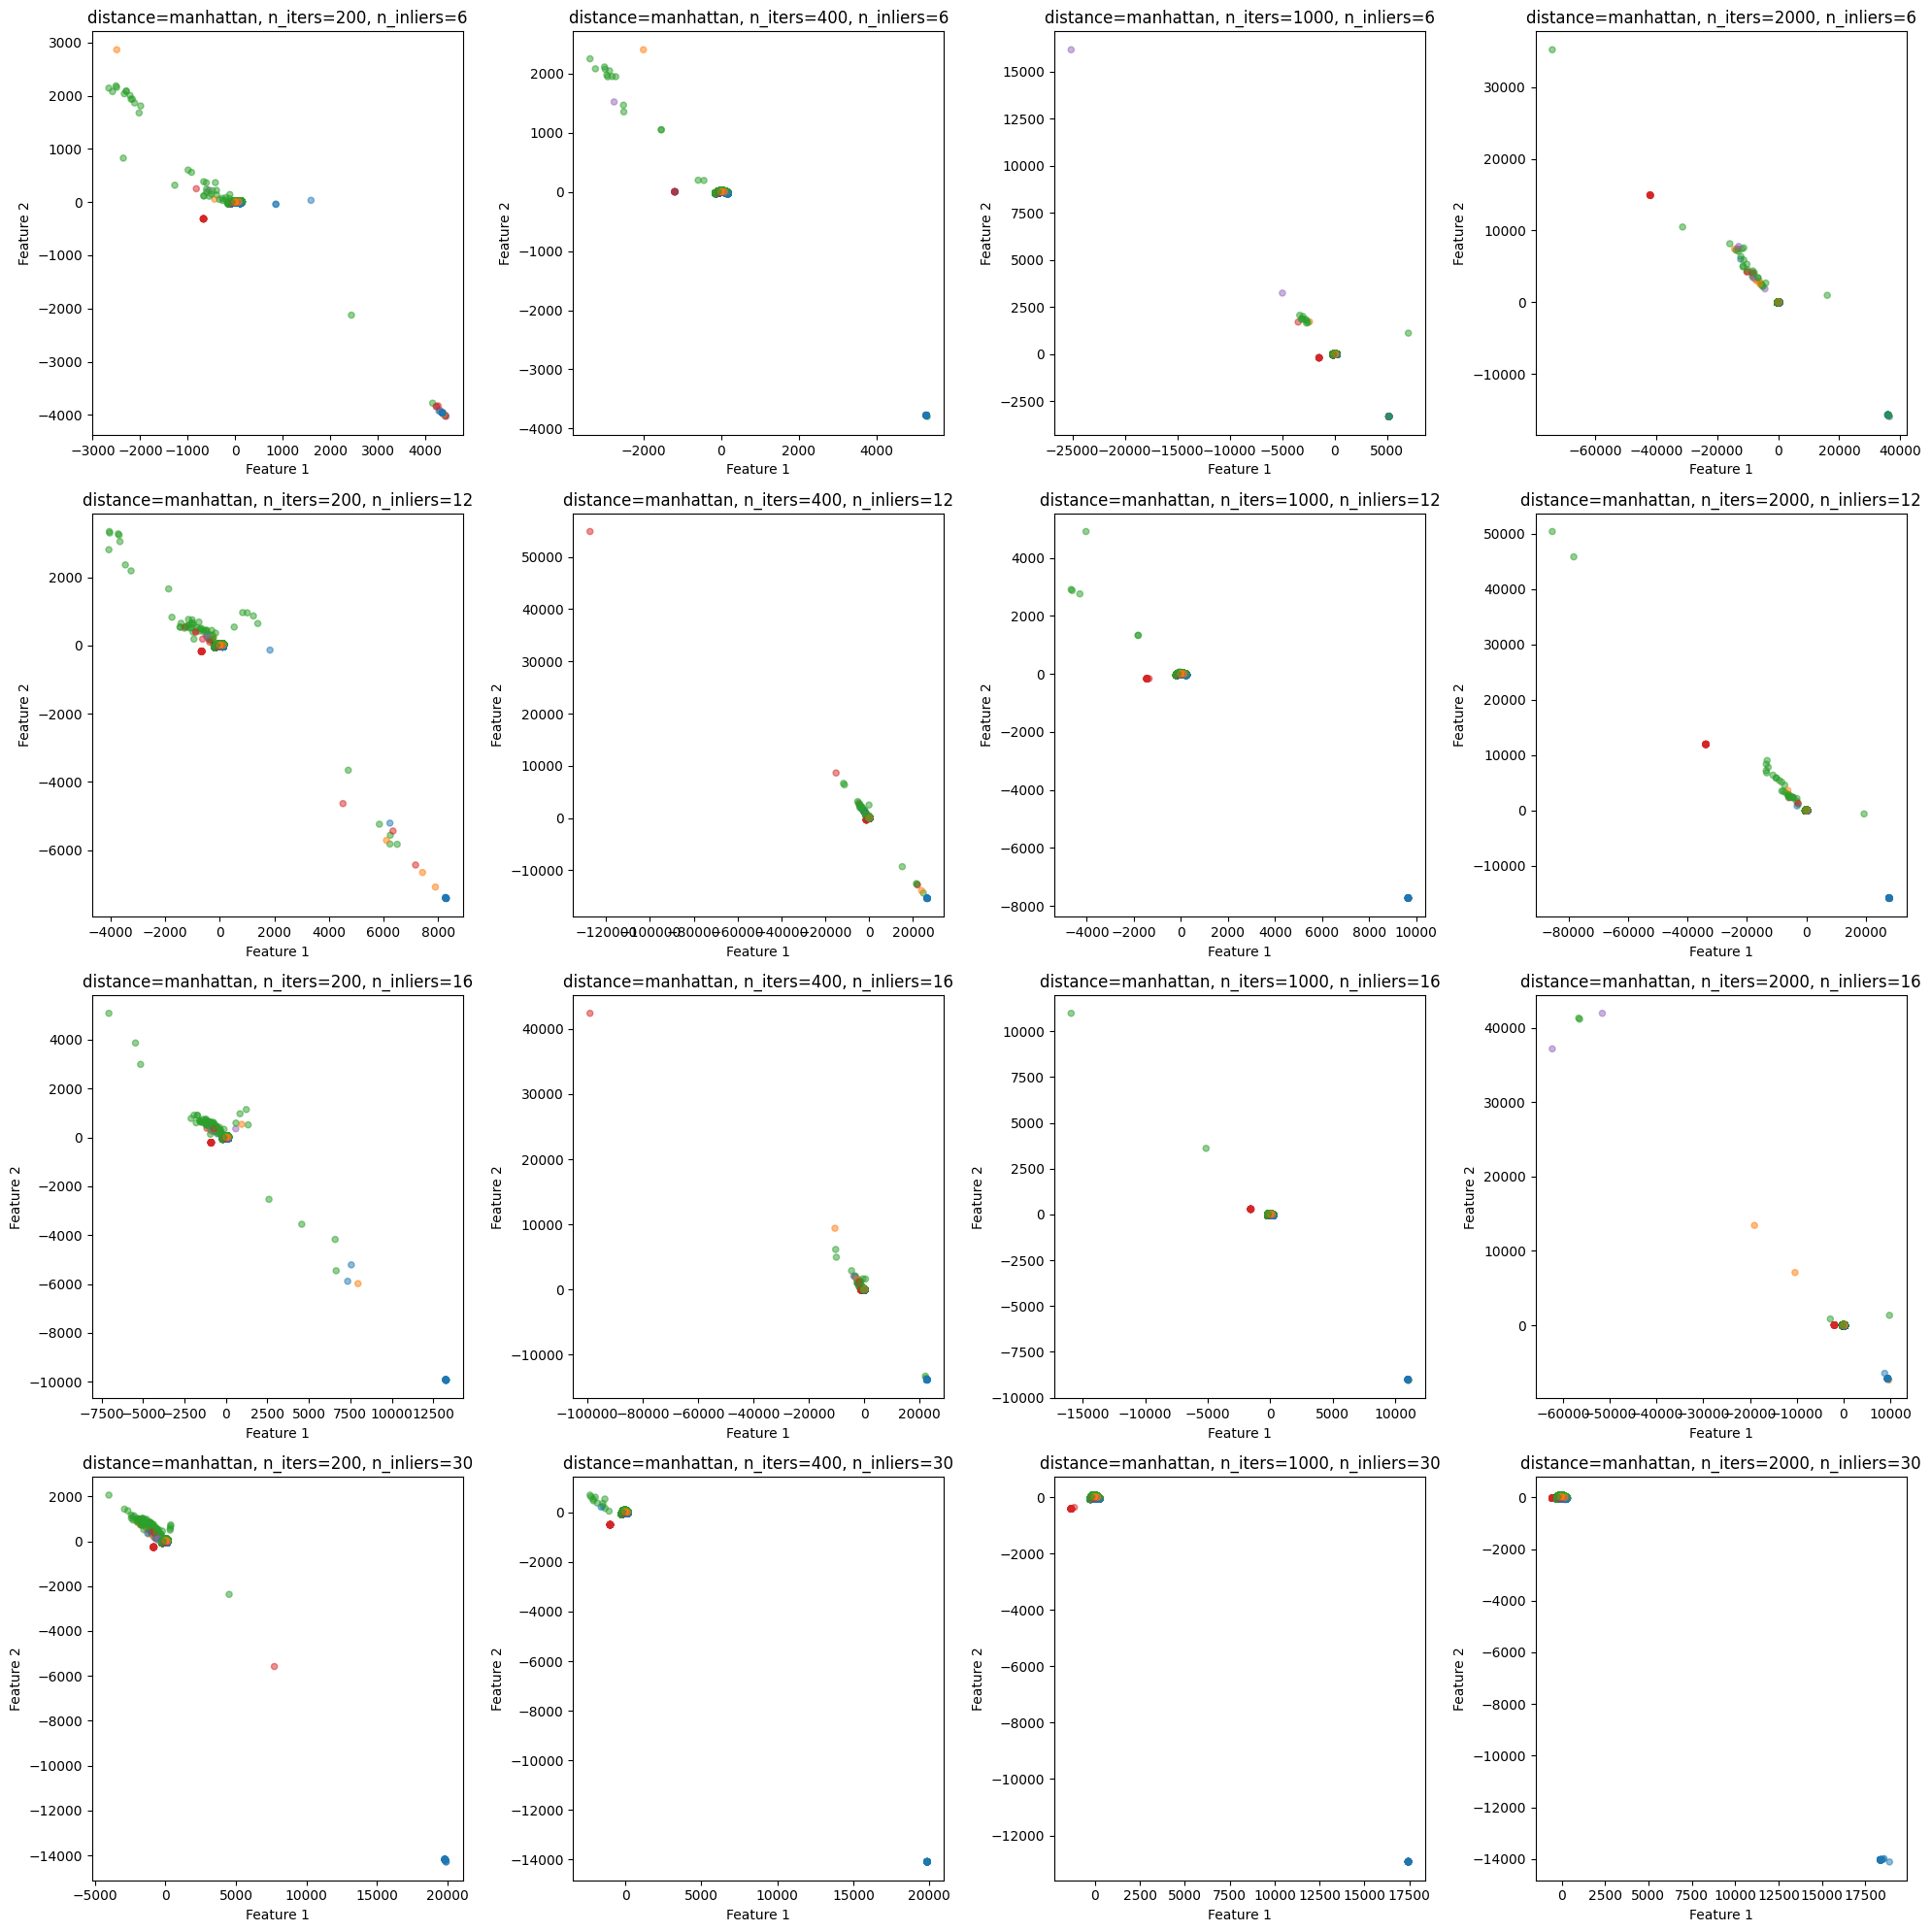

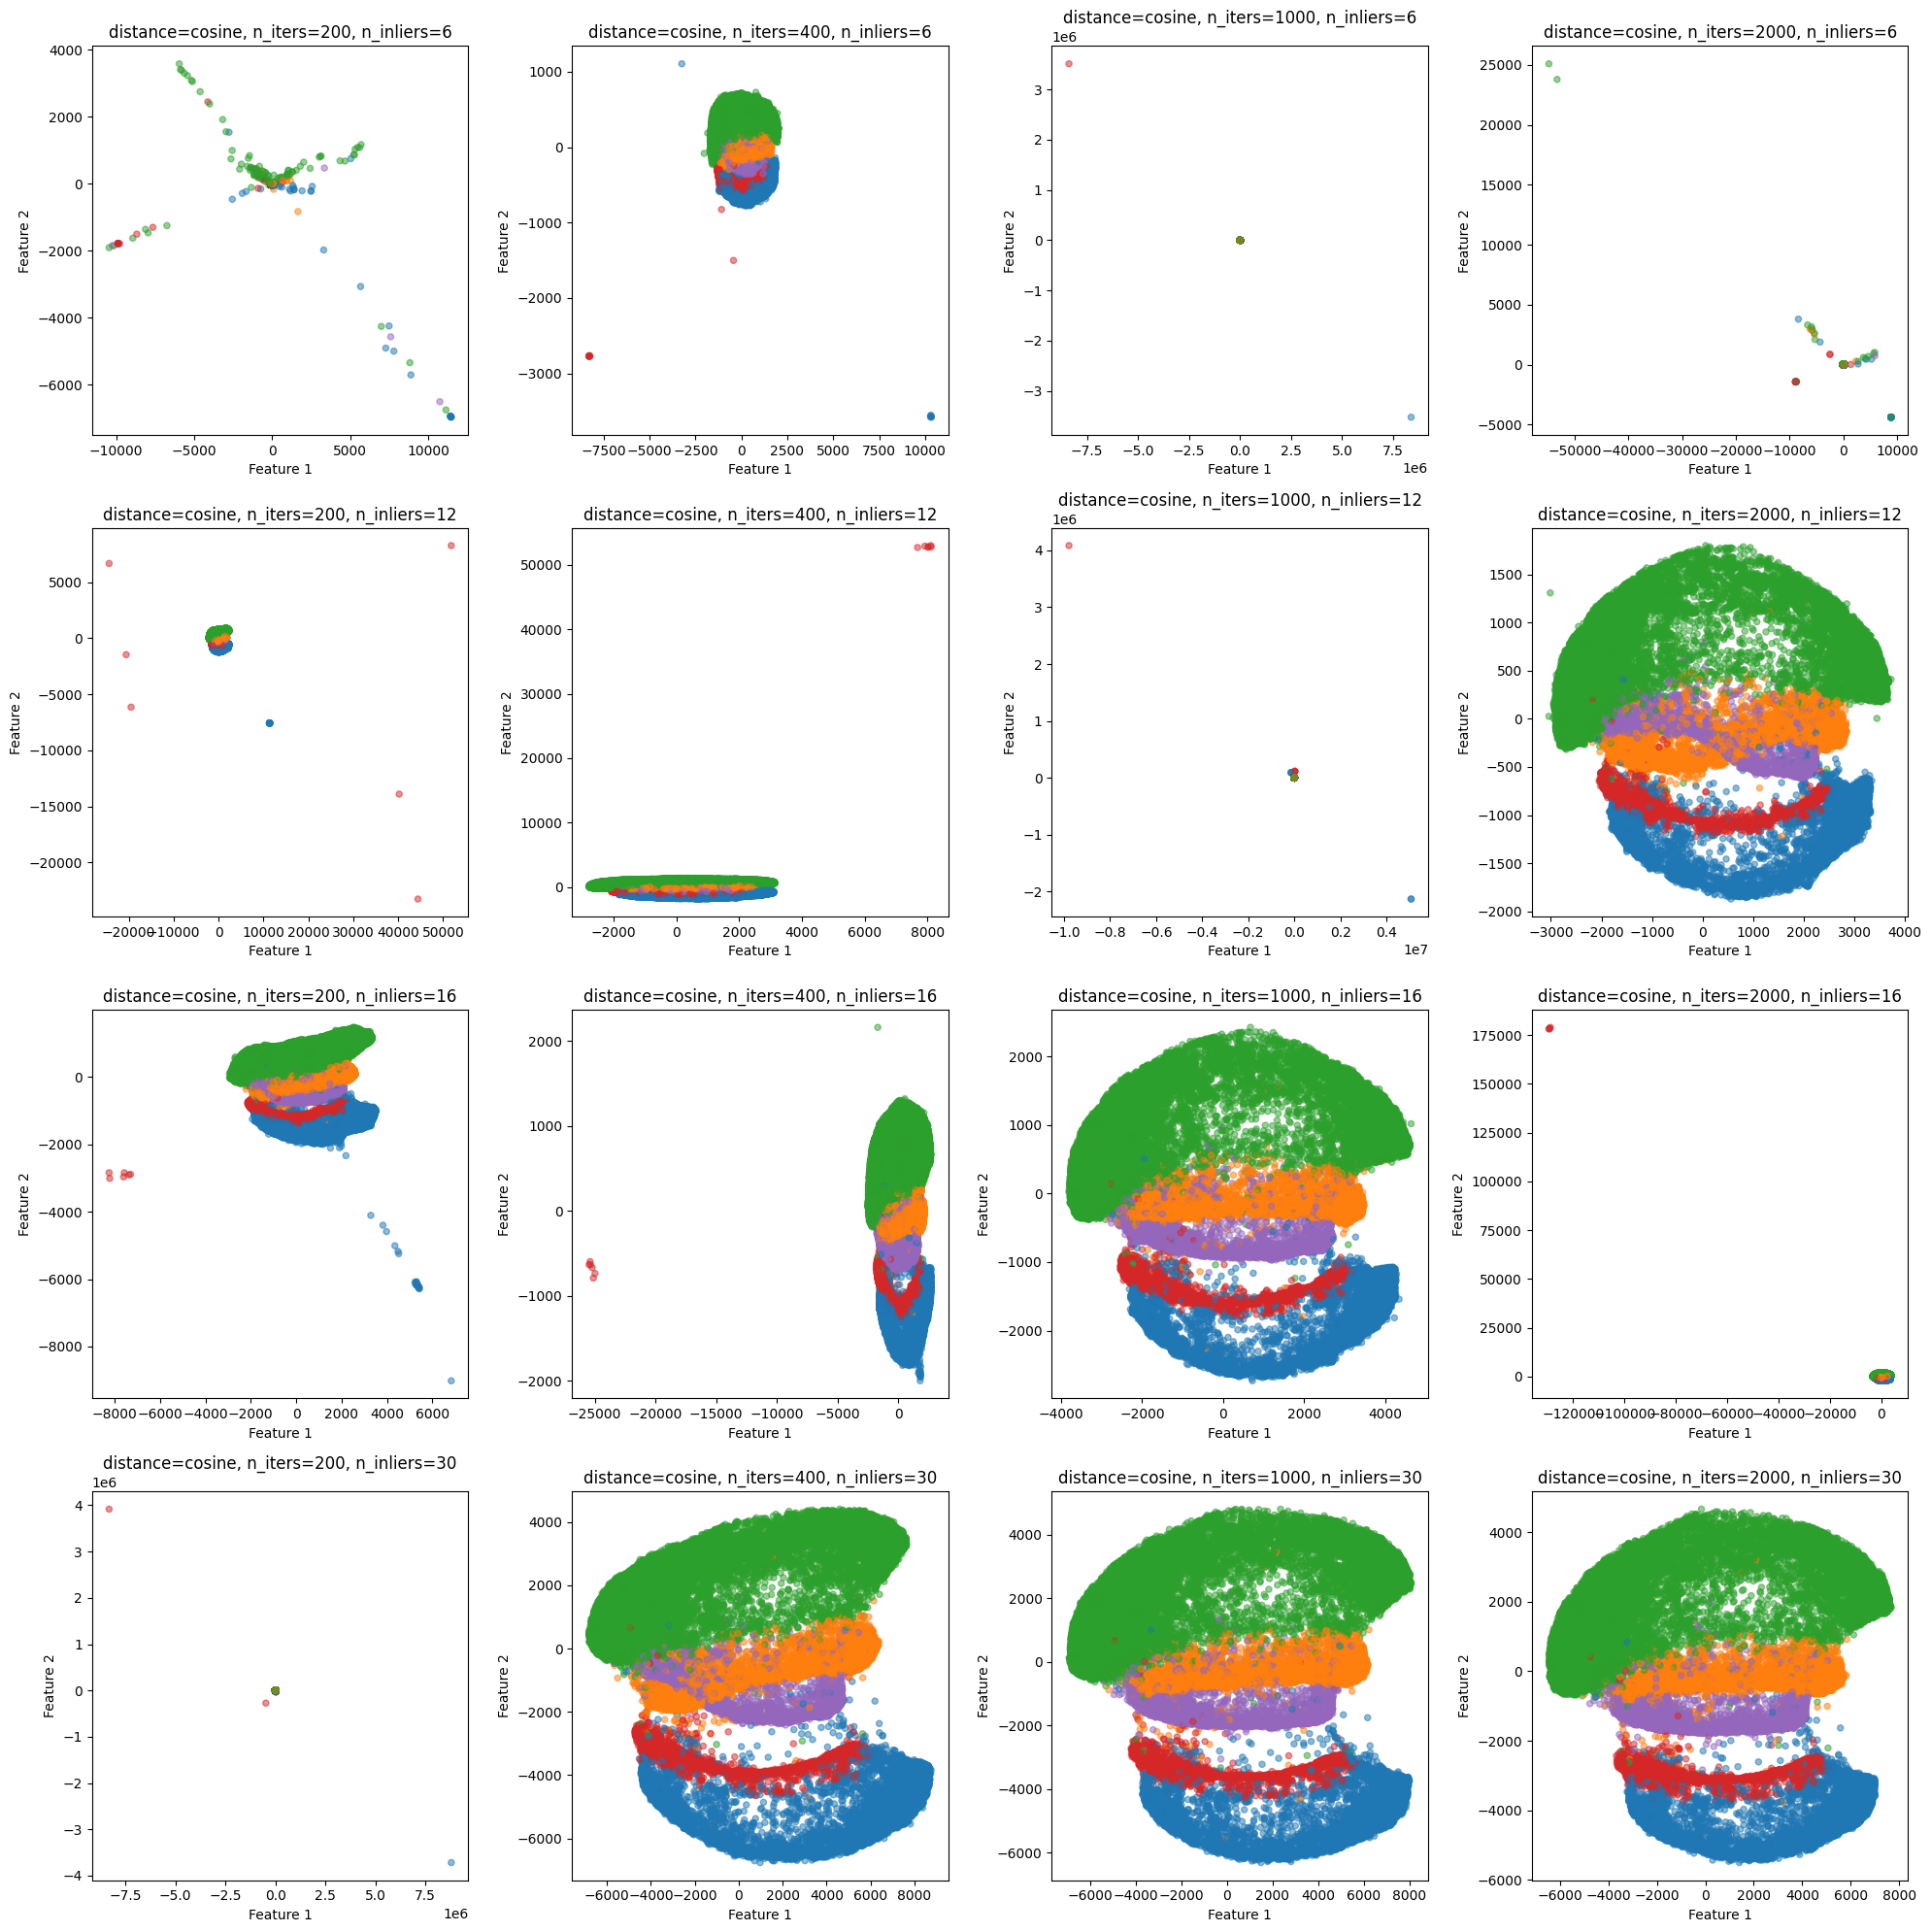

In [ ]:
for distance in ['euclidean', 'manhattan', 'cosine']:
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    axs = axs.flatten()
    i = 0
    for n_inliers in [6, 12, 16, 30]:
        for n_iters in [200, 400, 1000, 2000]:
            umap_post = TRIMAP(n_dims=2 , n_iters=n_iters, n_inliers=n_inliers, distance=distance)
            umap_results = umap_post.fit_transform(embeddings)

            plot_no_show(axs[i], umap_results, data_y_cpu, f'distance={distance}, n_iters={n_iters}, n_inliers={n_inliers}', size=20)

            i += 1


    plt.tight_layout()
    plt.show()

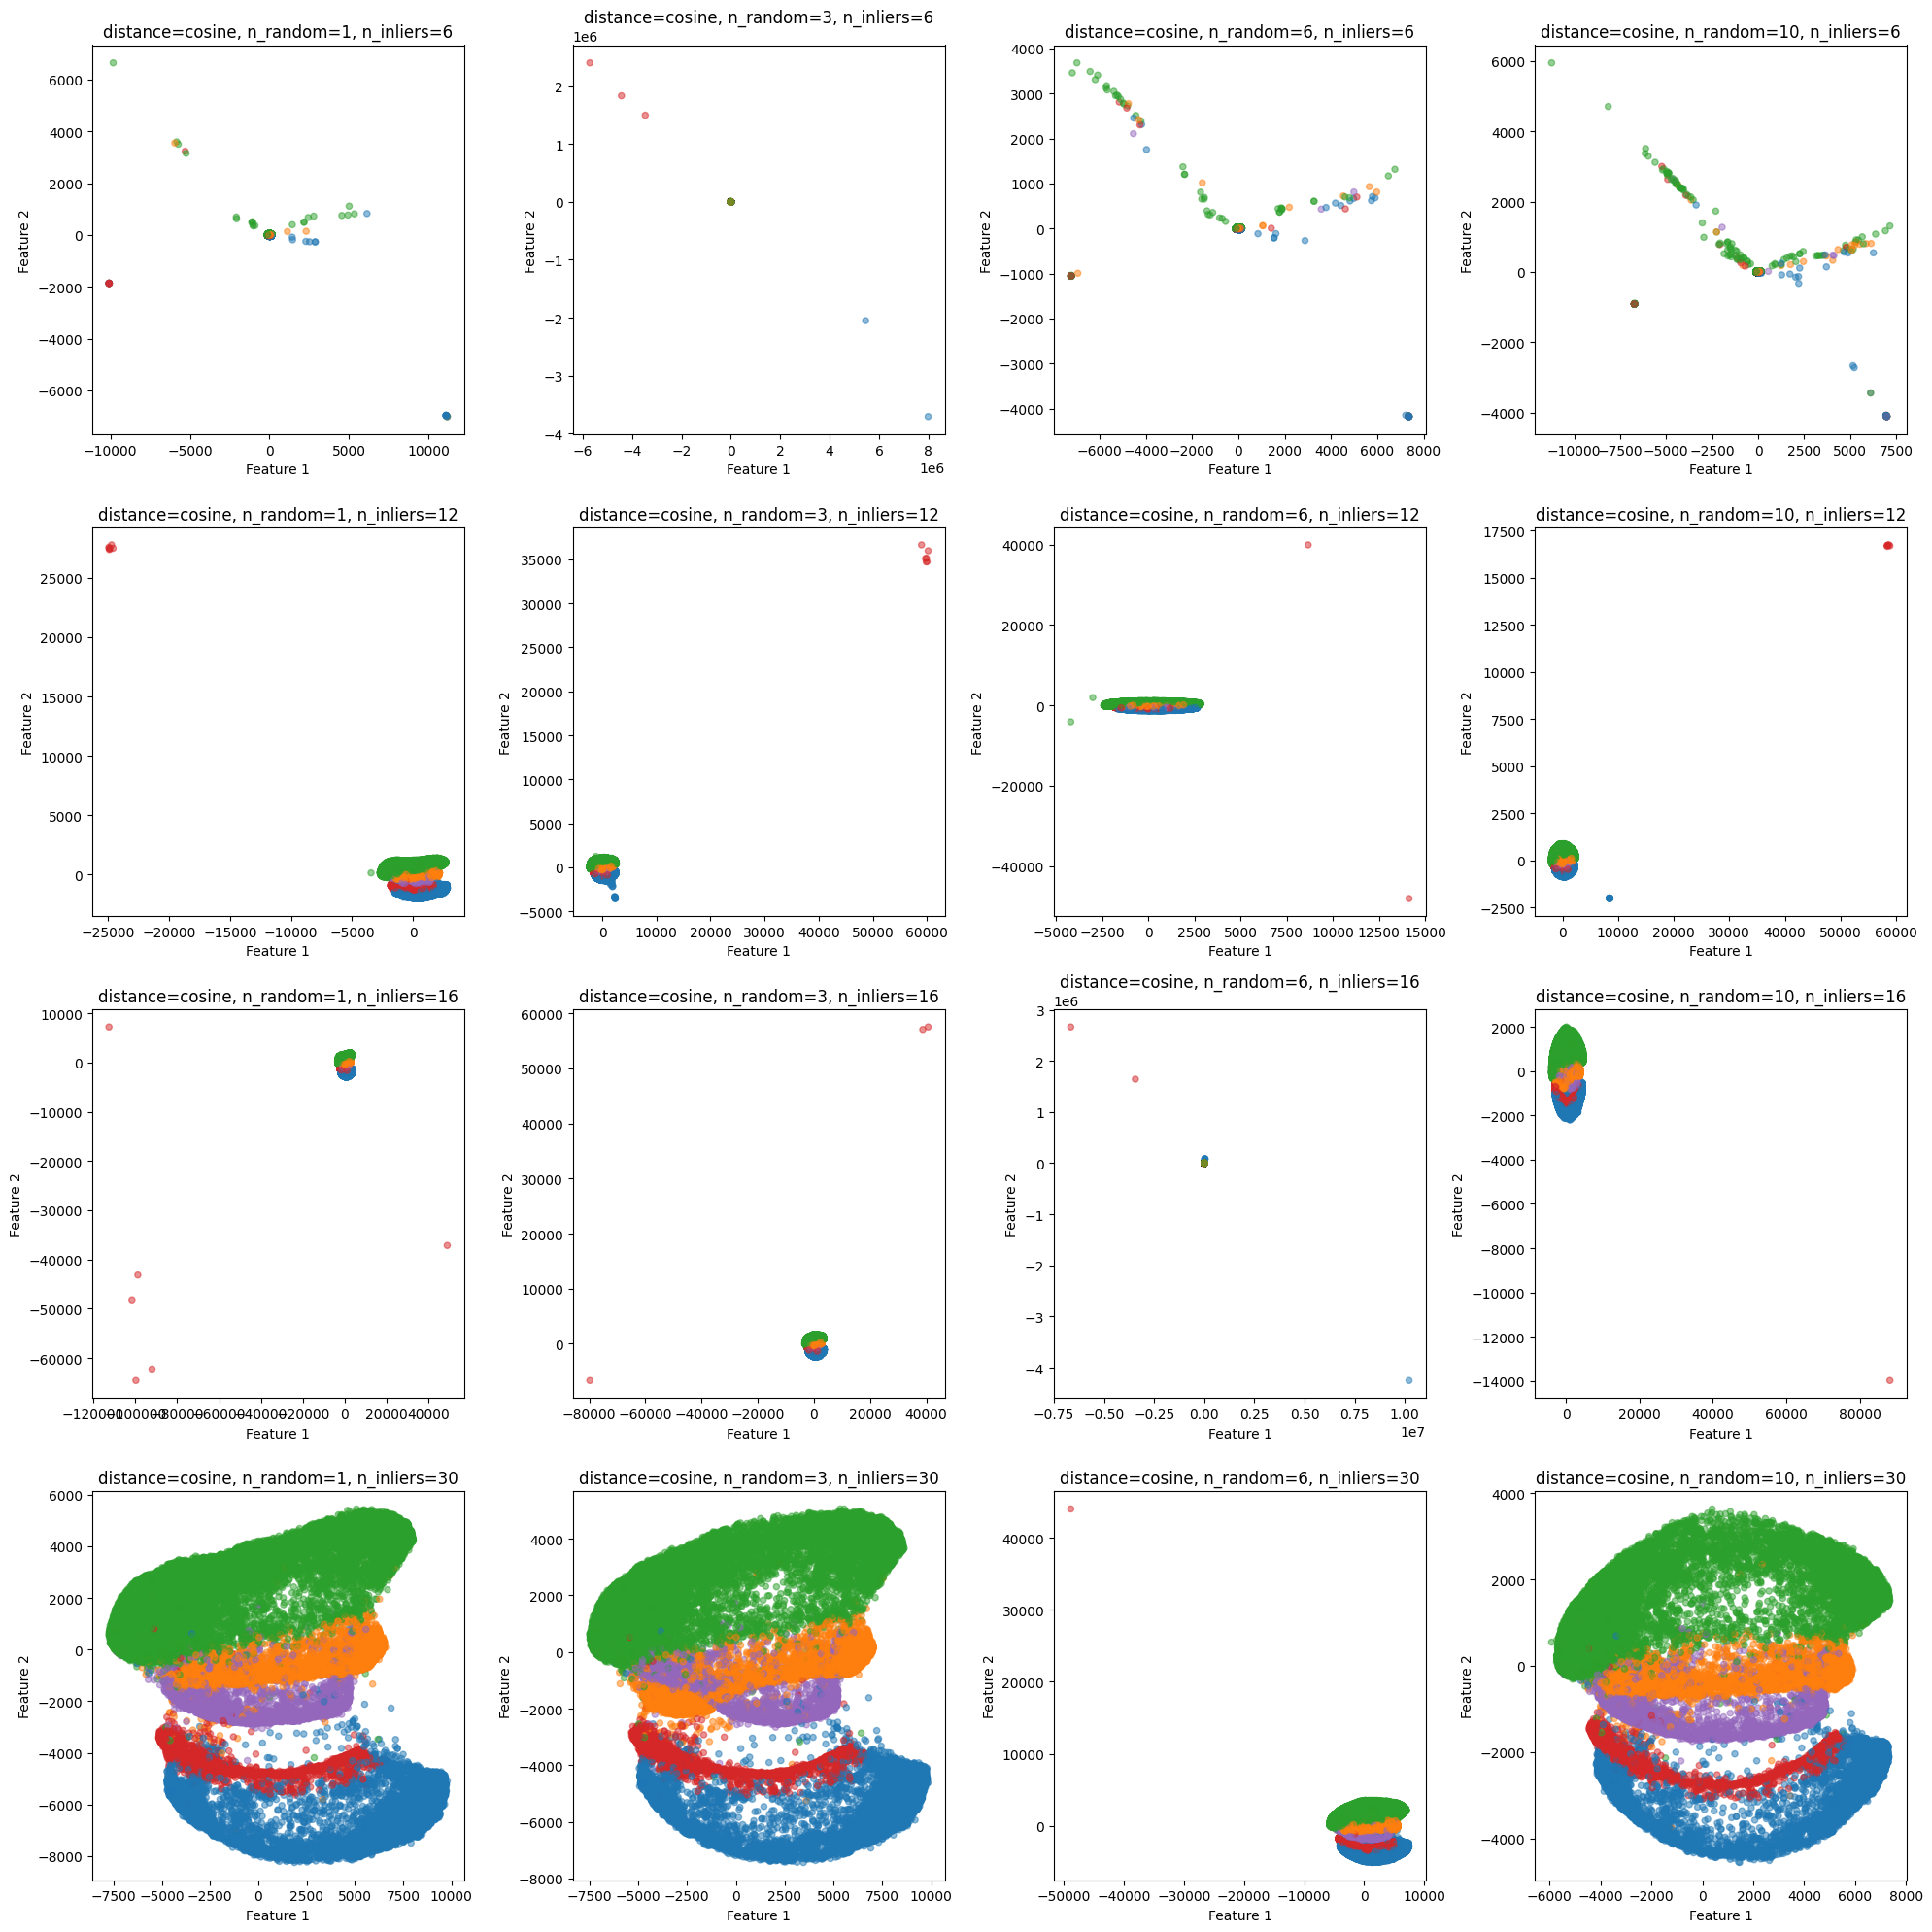

In [ ]:
distance = 'cosine'
n_iters=400
for distance in ['cosine']:
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    axs = axs.flatten()
    i = 0
    for n_inliers in [6, 12, 16, 30]:
        for n_random in [1, 3, 6, 10]:
            umap_post = TRIMAP(n_dims=2 , n_random=n_random, n_inliers=n_inliers, distance=distance)
            umap_results = umap_post.fit_transform(embeddings)

            plot_no_show(axs[i], umap_results, data_y_cpu, f'distance={distance}, n_random={n_random}, n_inliers={n_inliers}', size=20)

            i += 1


    plt.tight_layout()
    plt.show()

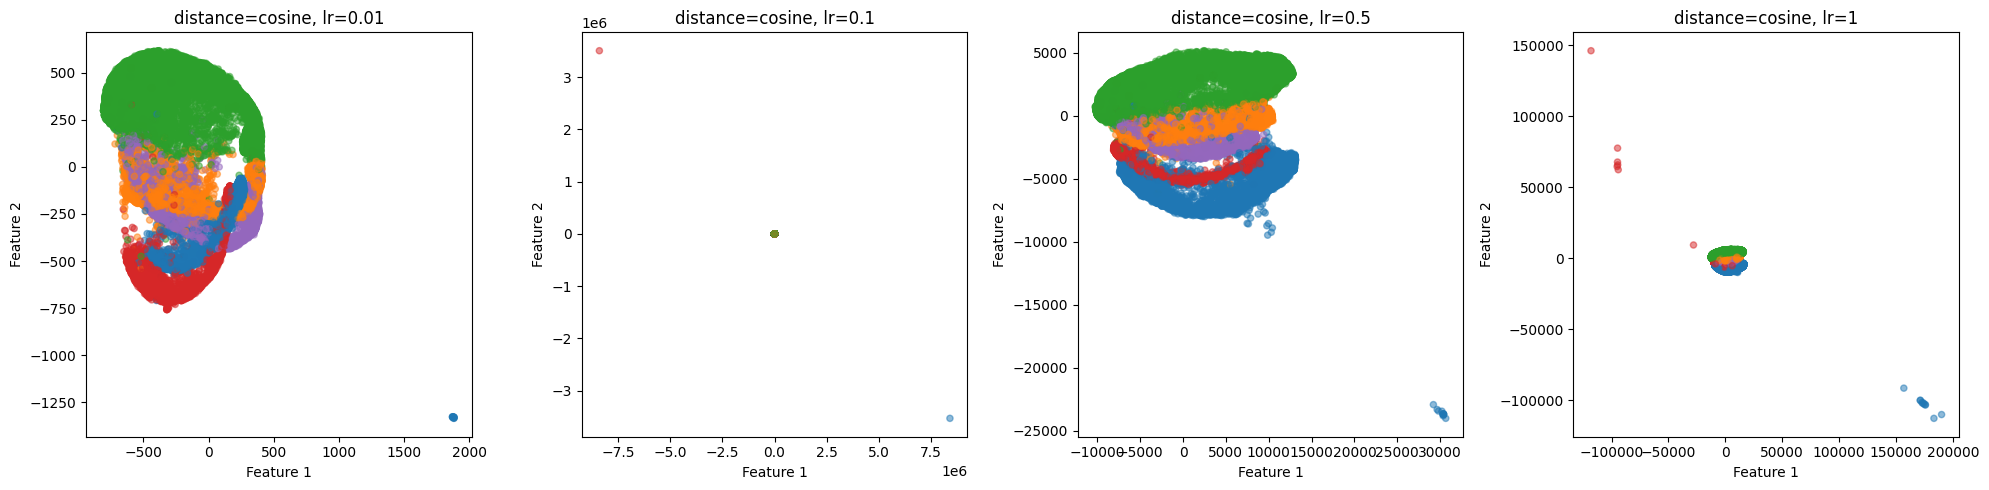

In [ ]:
distance = 'cosine'
n_iters=400
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs = axs.flatten()
i = 0

for lr in [0.01, 0.1, 0.5, 1]:
    umap_post = TRIMAP(n_dims=2, distance=distance, lr=lr)
    umap_results = umap_post.fit_transform(embeddings)

    plot_no_show(axs[i], umap_results, data_y_cpu, f'distance={distance}, lr={lr}', size=20)

    i += 1


plt.tight_layout()
plt.show()

The best distance seems to be **cosine**. Let's discard n_outliers=3 and n_inliners=0 and investigate further.

### 2.3 Fine-tuned TRIMAP vs default TRIMAP

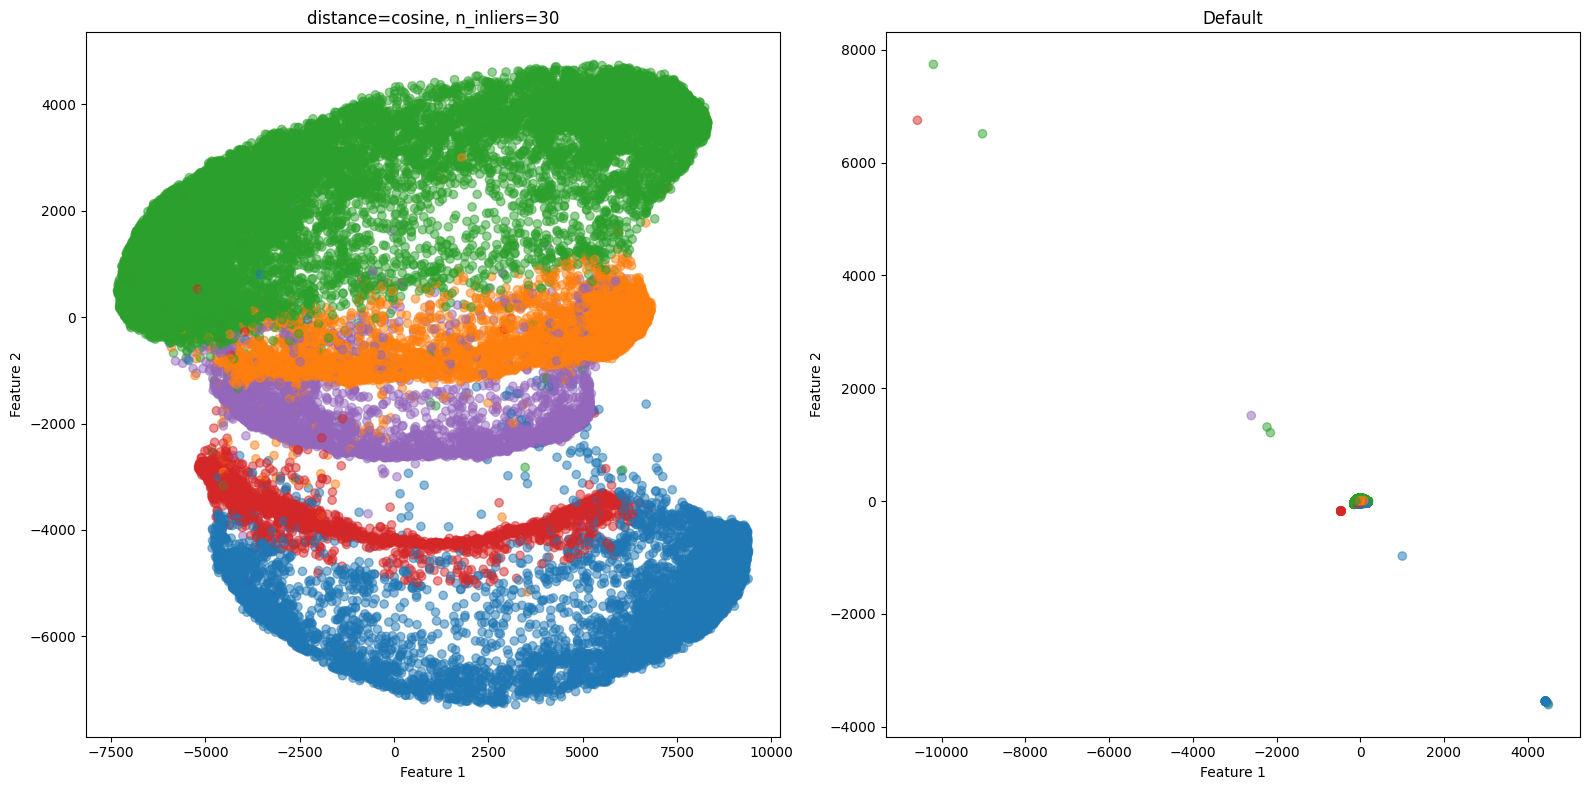

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

distance='cosine'
n_inliers=30

umap_post = TRIMAP(n_dims=2, distance=distance, n_inliers=n_inliers)
umap_results = umap_post.fit_transform(embeddings)

plot_no_show(axs[0], umap_results, data_y_cpu, f'distance={distance}, n_inliers={n_inliers}')

umap_post = TRIMAP(n_dims=2)
umap_results = umap_post.fit_transform(embeddings)

plot_no_show(axs[1], umap_results, data_y_cpu, f'Default')

plt.tight_layout()
plt.show()

The results are extremely poor. Let's investigate if manipulating model parameters will improve the outcome.

## 4. TRIMAP on original features

### 4.1 Default umap

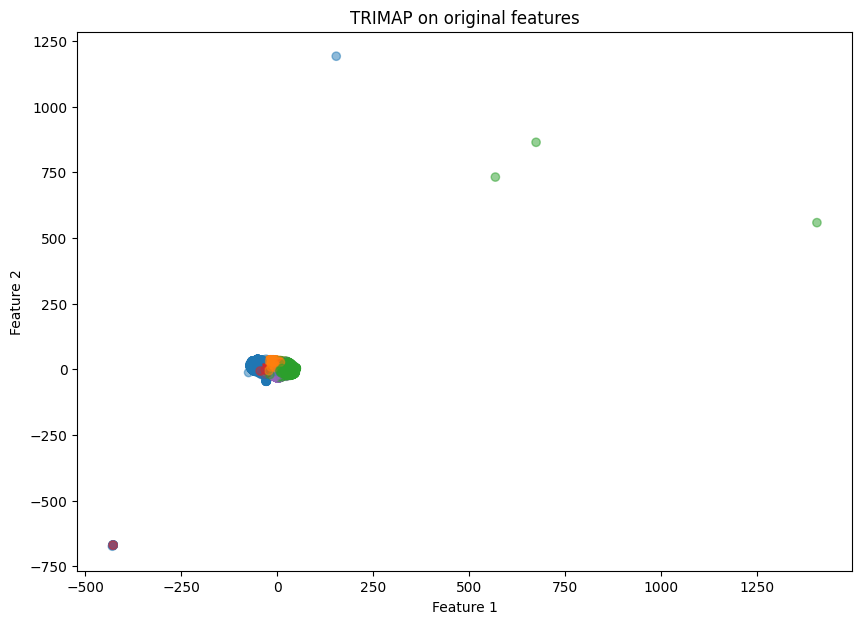

In [10]:
umap_post = TRIMAP(n_dims=2)
embeddings_umap_post = umap_post.fit_transform(data_x_cpu)

visualise(embeddings_umap_post, data_y_cpu, 'TRIMAP on original features')

### 4.2 Fine-tuning umap

#### 4.2.1 distance vs n_inliners vs n_outliers

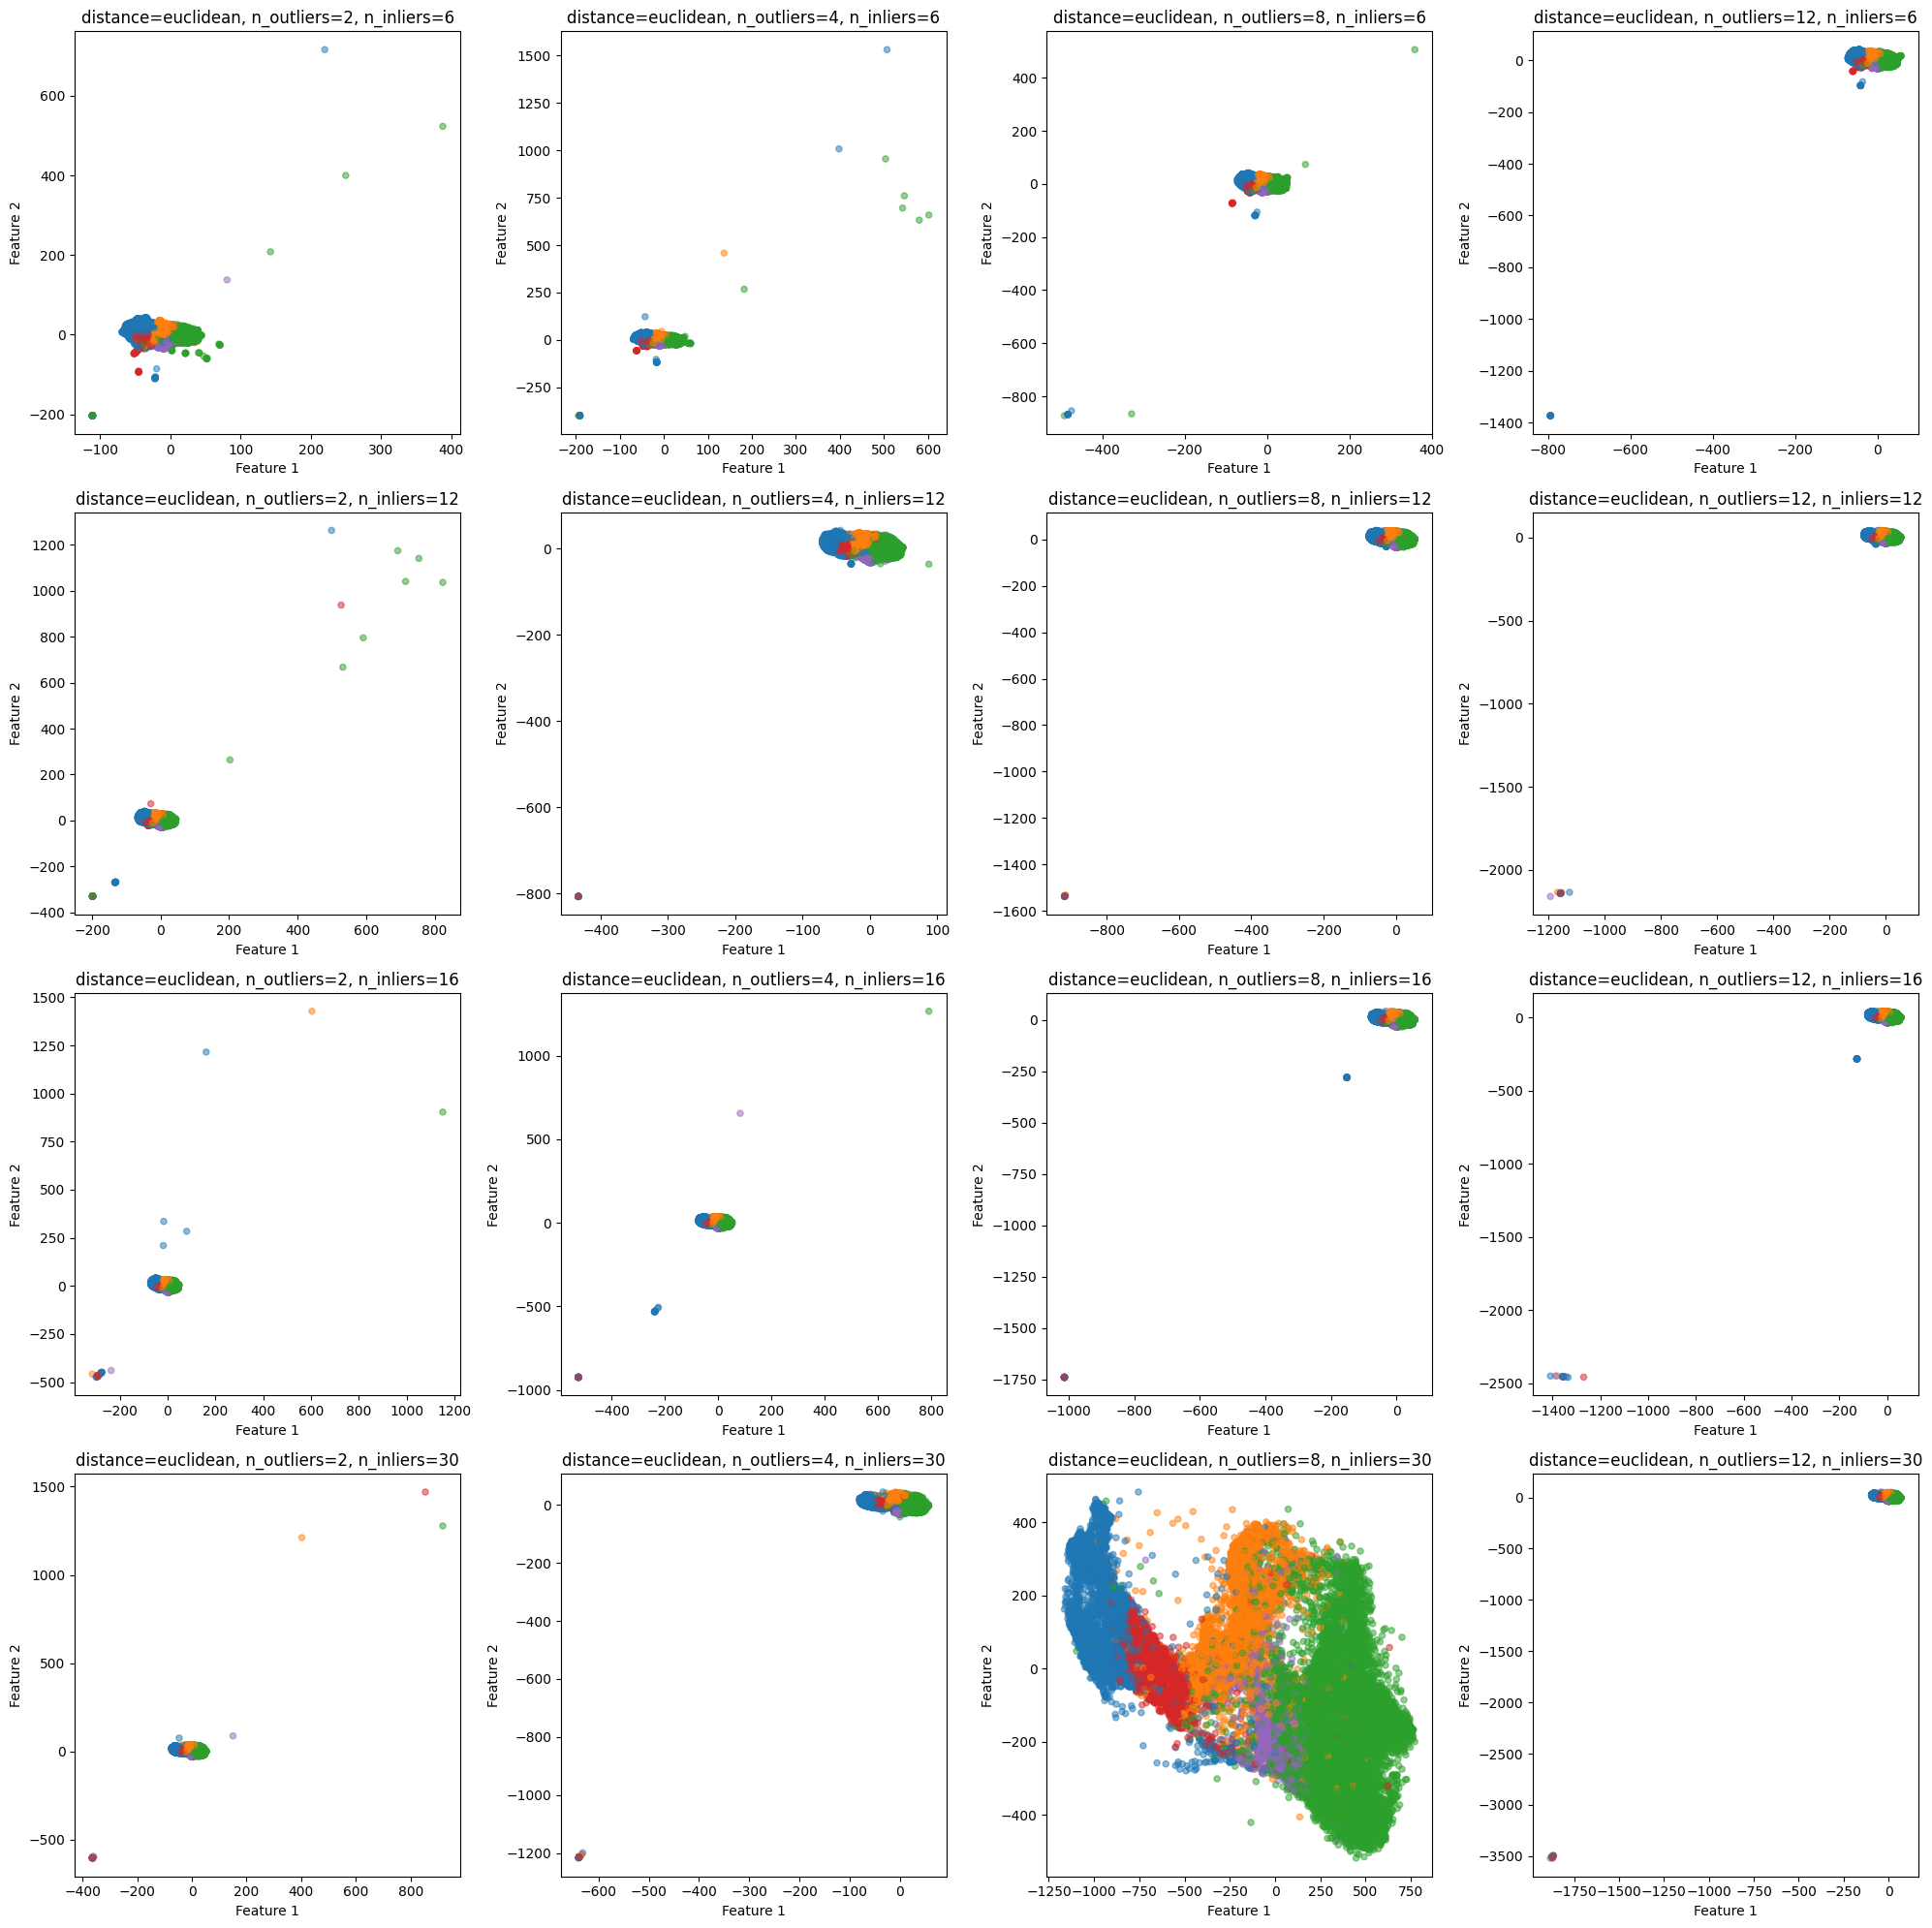

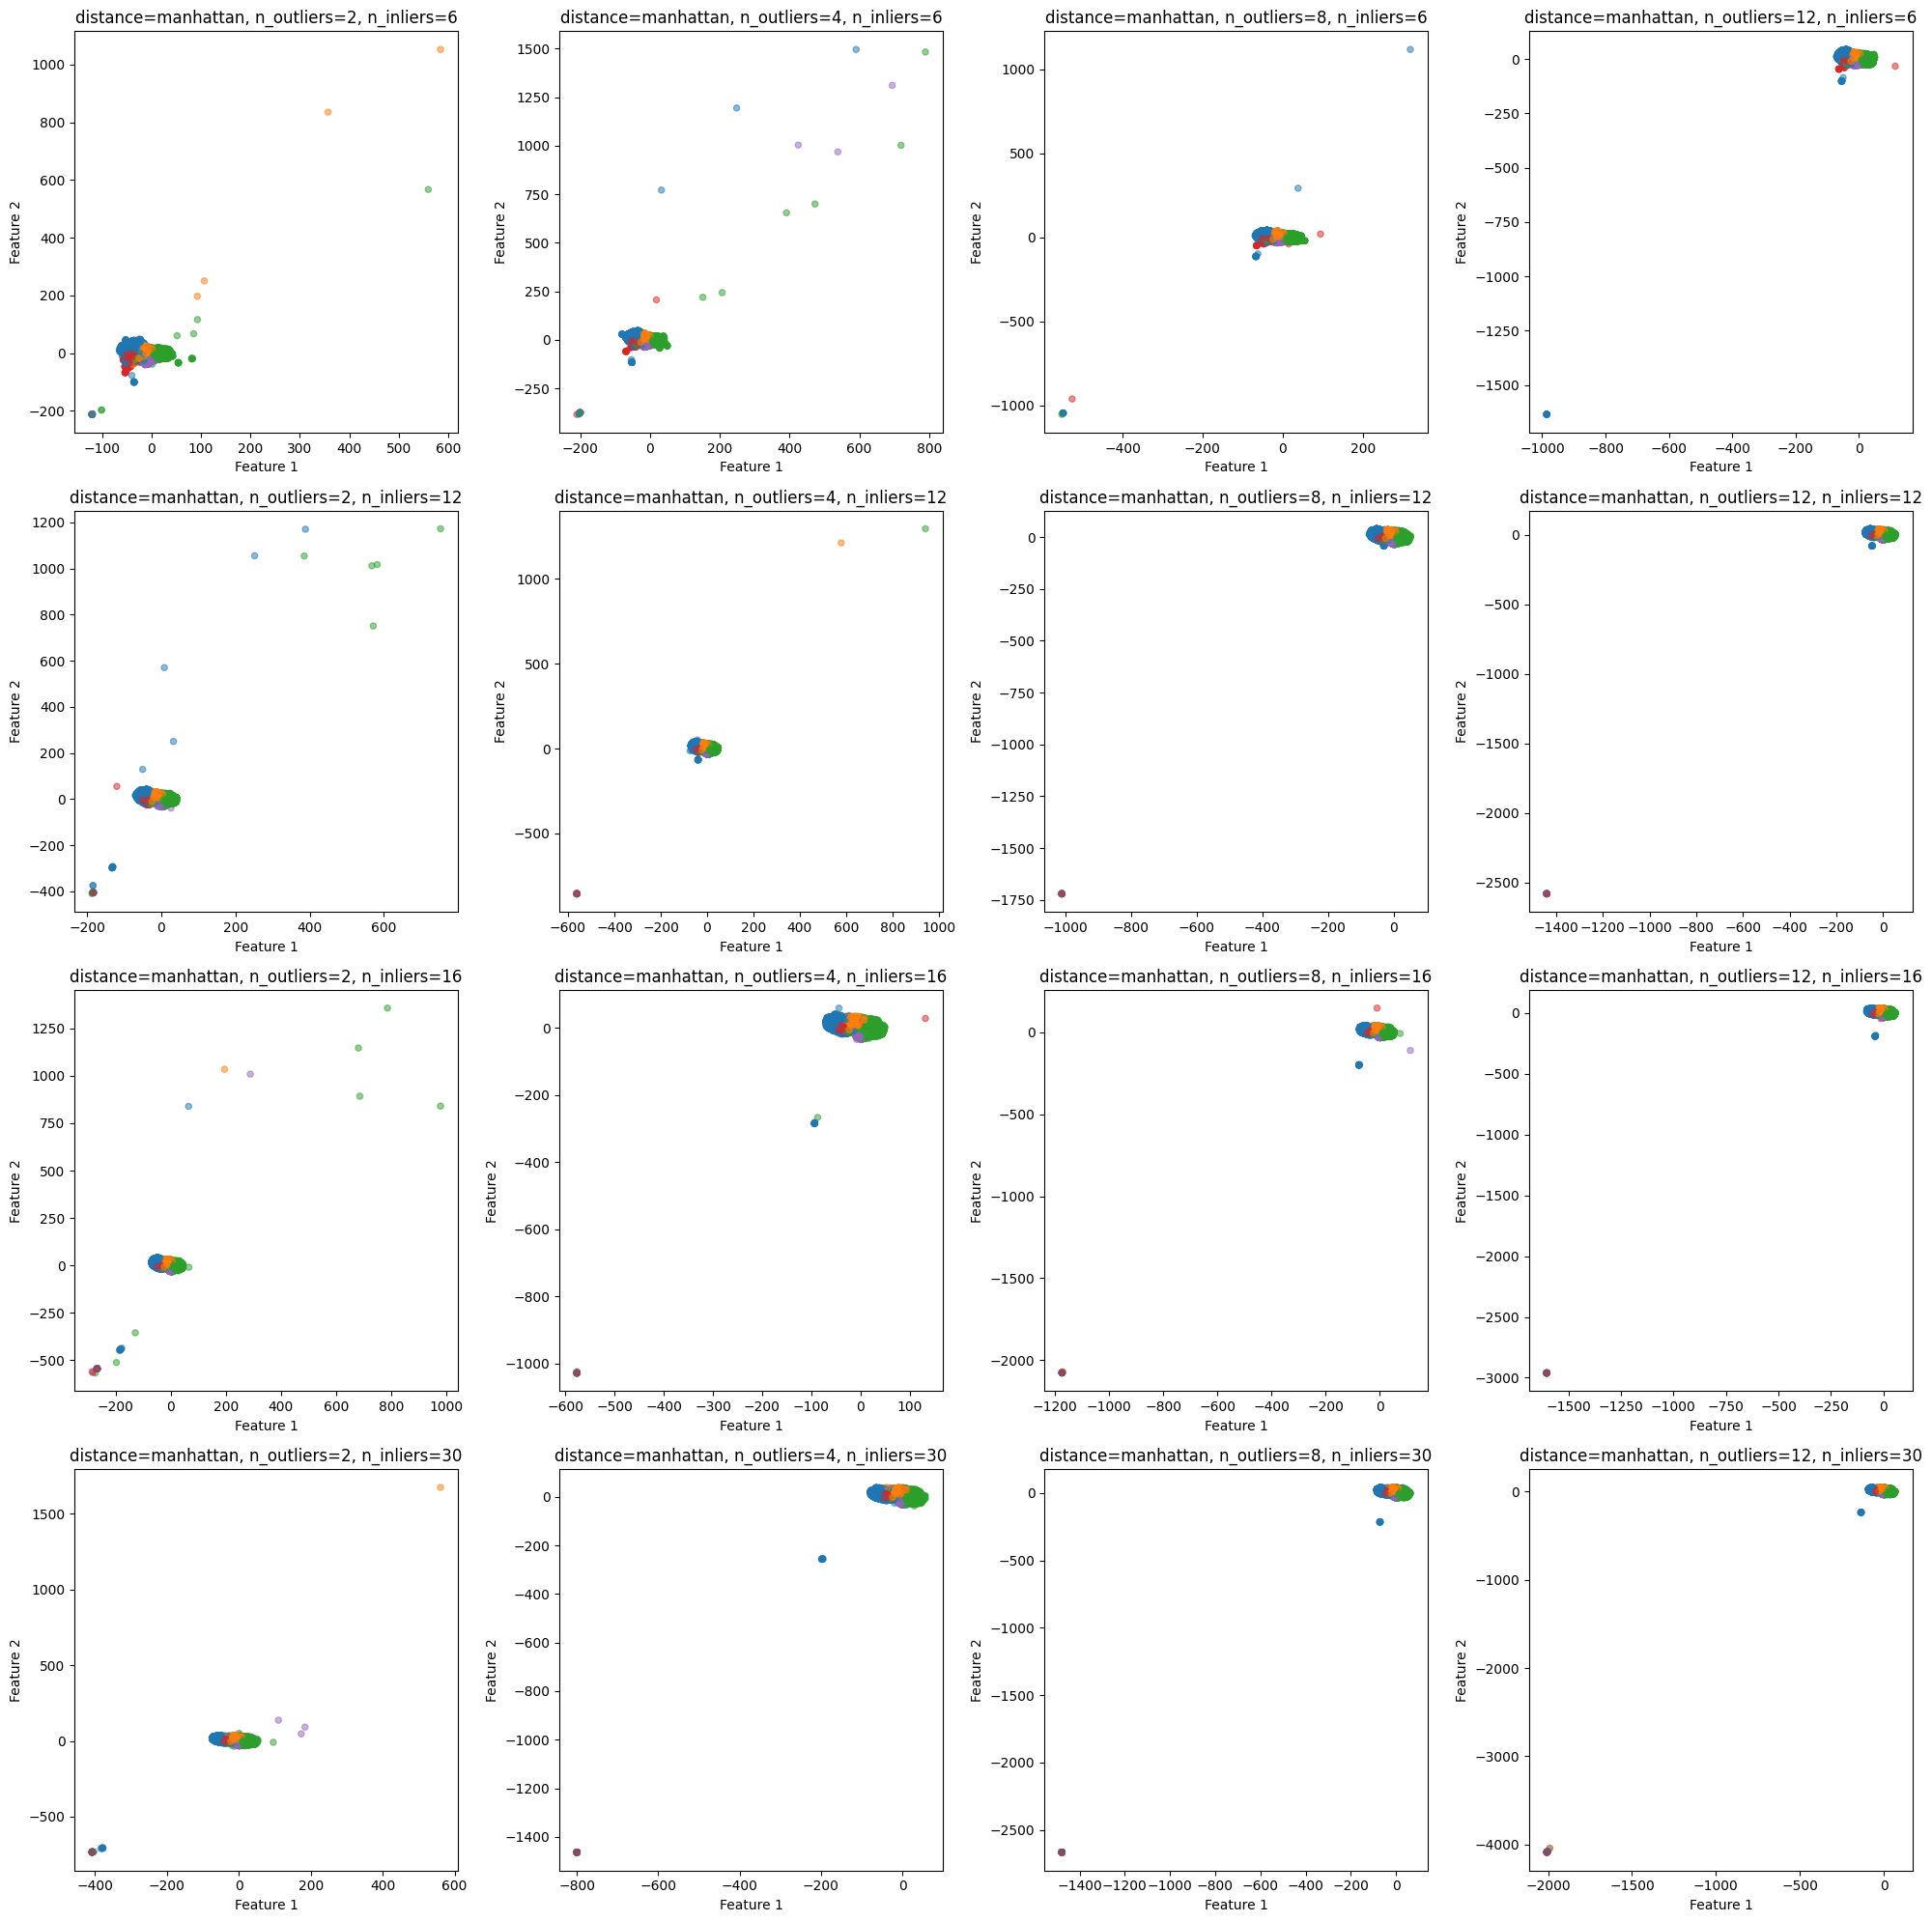

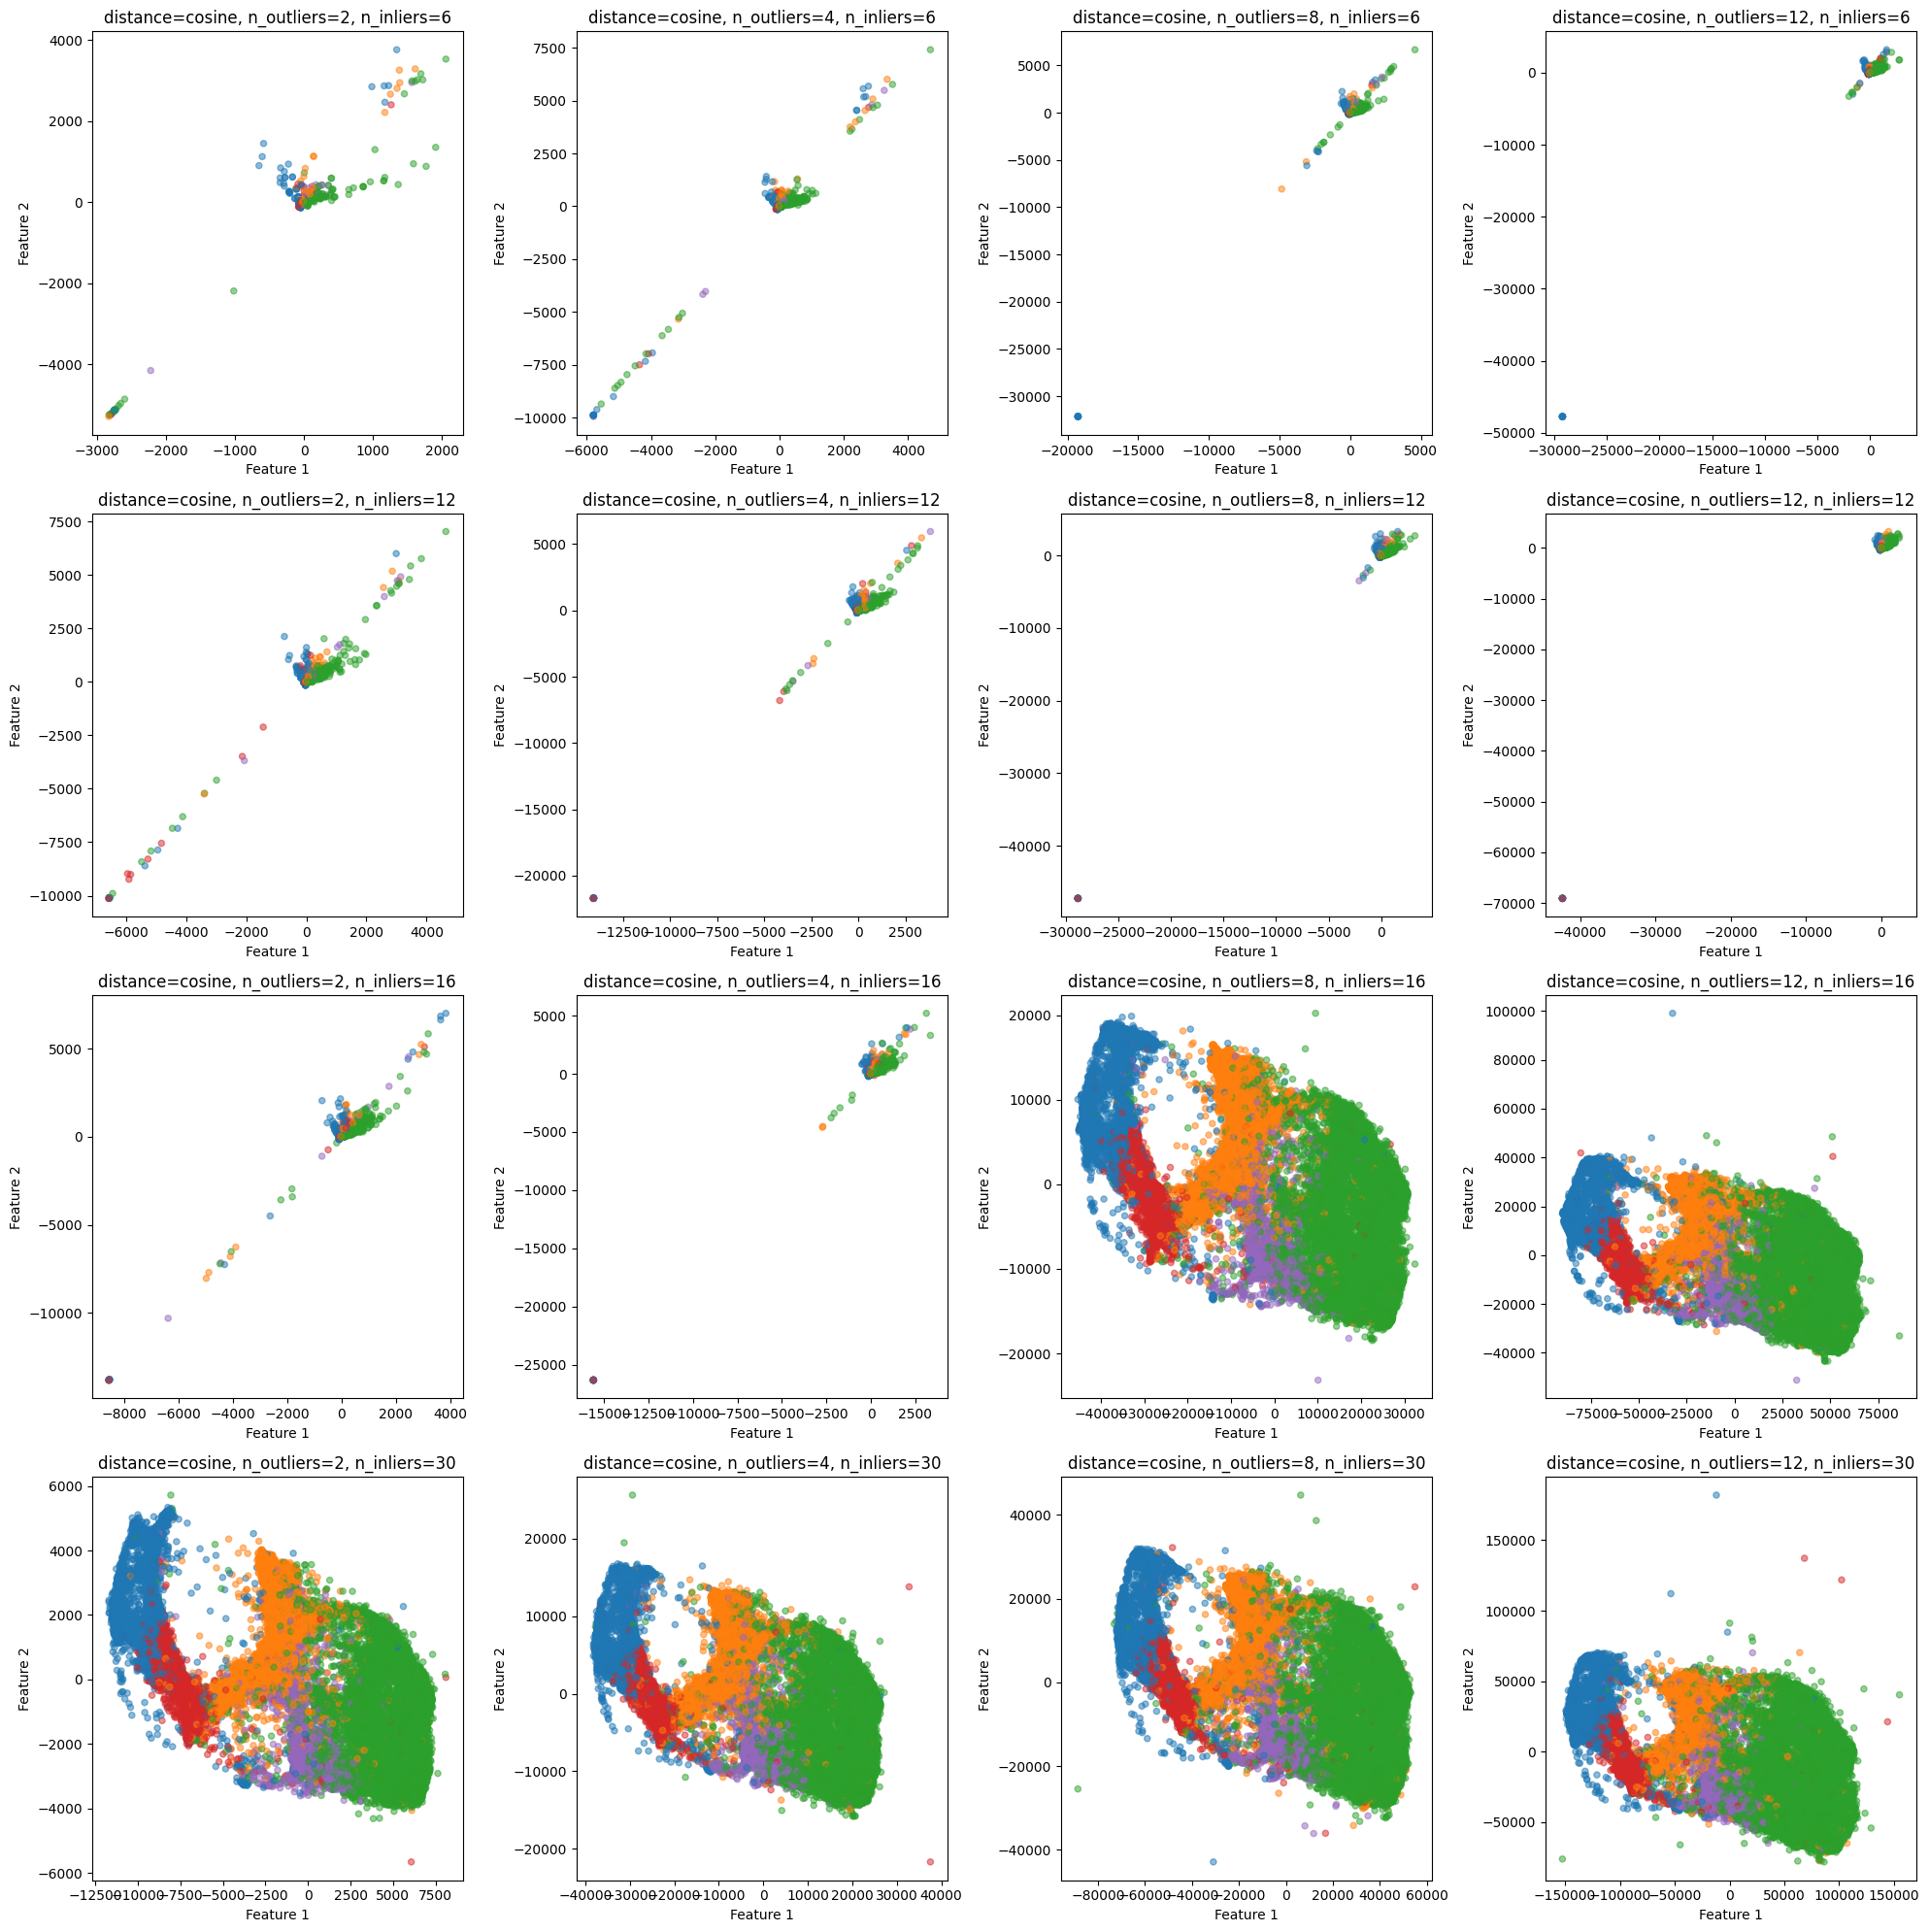

In [11]:
for distance in ['euclidean', 'manhattan', 'cosine']:
    fig, axs = plt.subplots(4, 4, figsize=(20, 20))
    axs = axs.flatten()
    i = 0
    for n_inliers in  [6, 12, 16, 30]:
        for n_outliers in [2, 4, 8, 12]:

            umap_post = TRIMAP(n_dims=2, n_outliers=n_outliers, n_inliers=n_inliers, distance=distance)
            umap_results = umap_post.fit_transform(data_x_cpu)

            plot_no_show(axs[i], umap_results, data_y_cpu, f'distance={distance}, n_outliers={n_outliers}, n_inliers={n_inliers}', size=20)

            i += 1


    plt.tight_layout()
    plt.show()



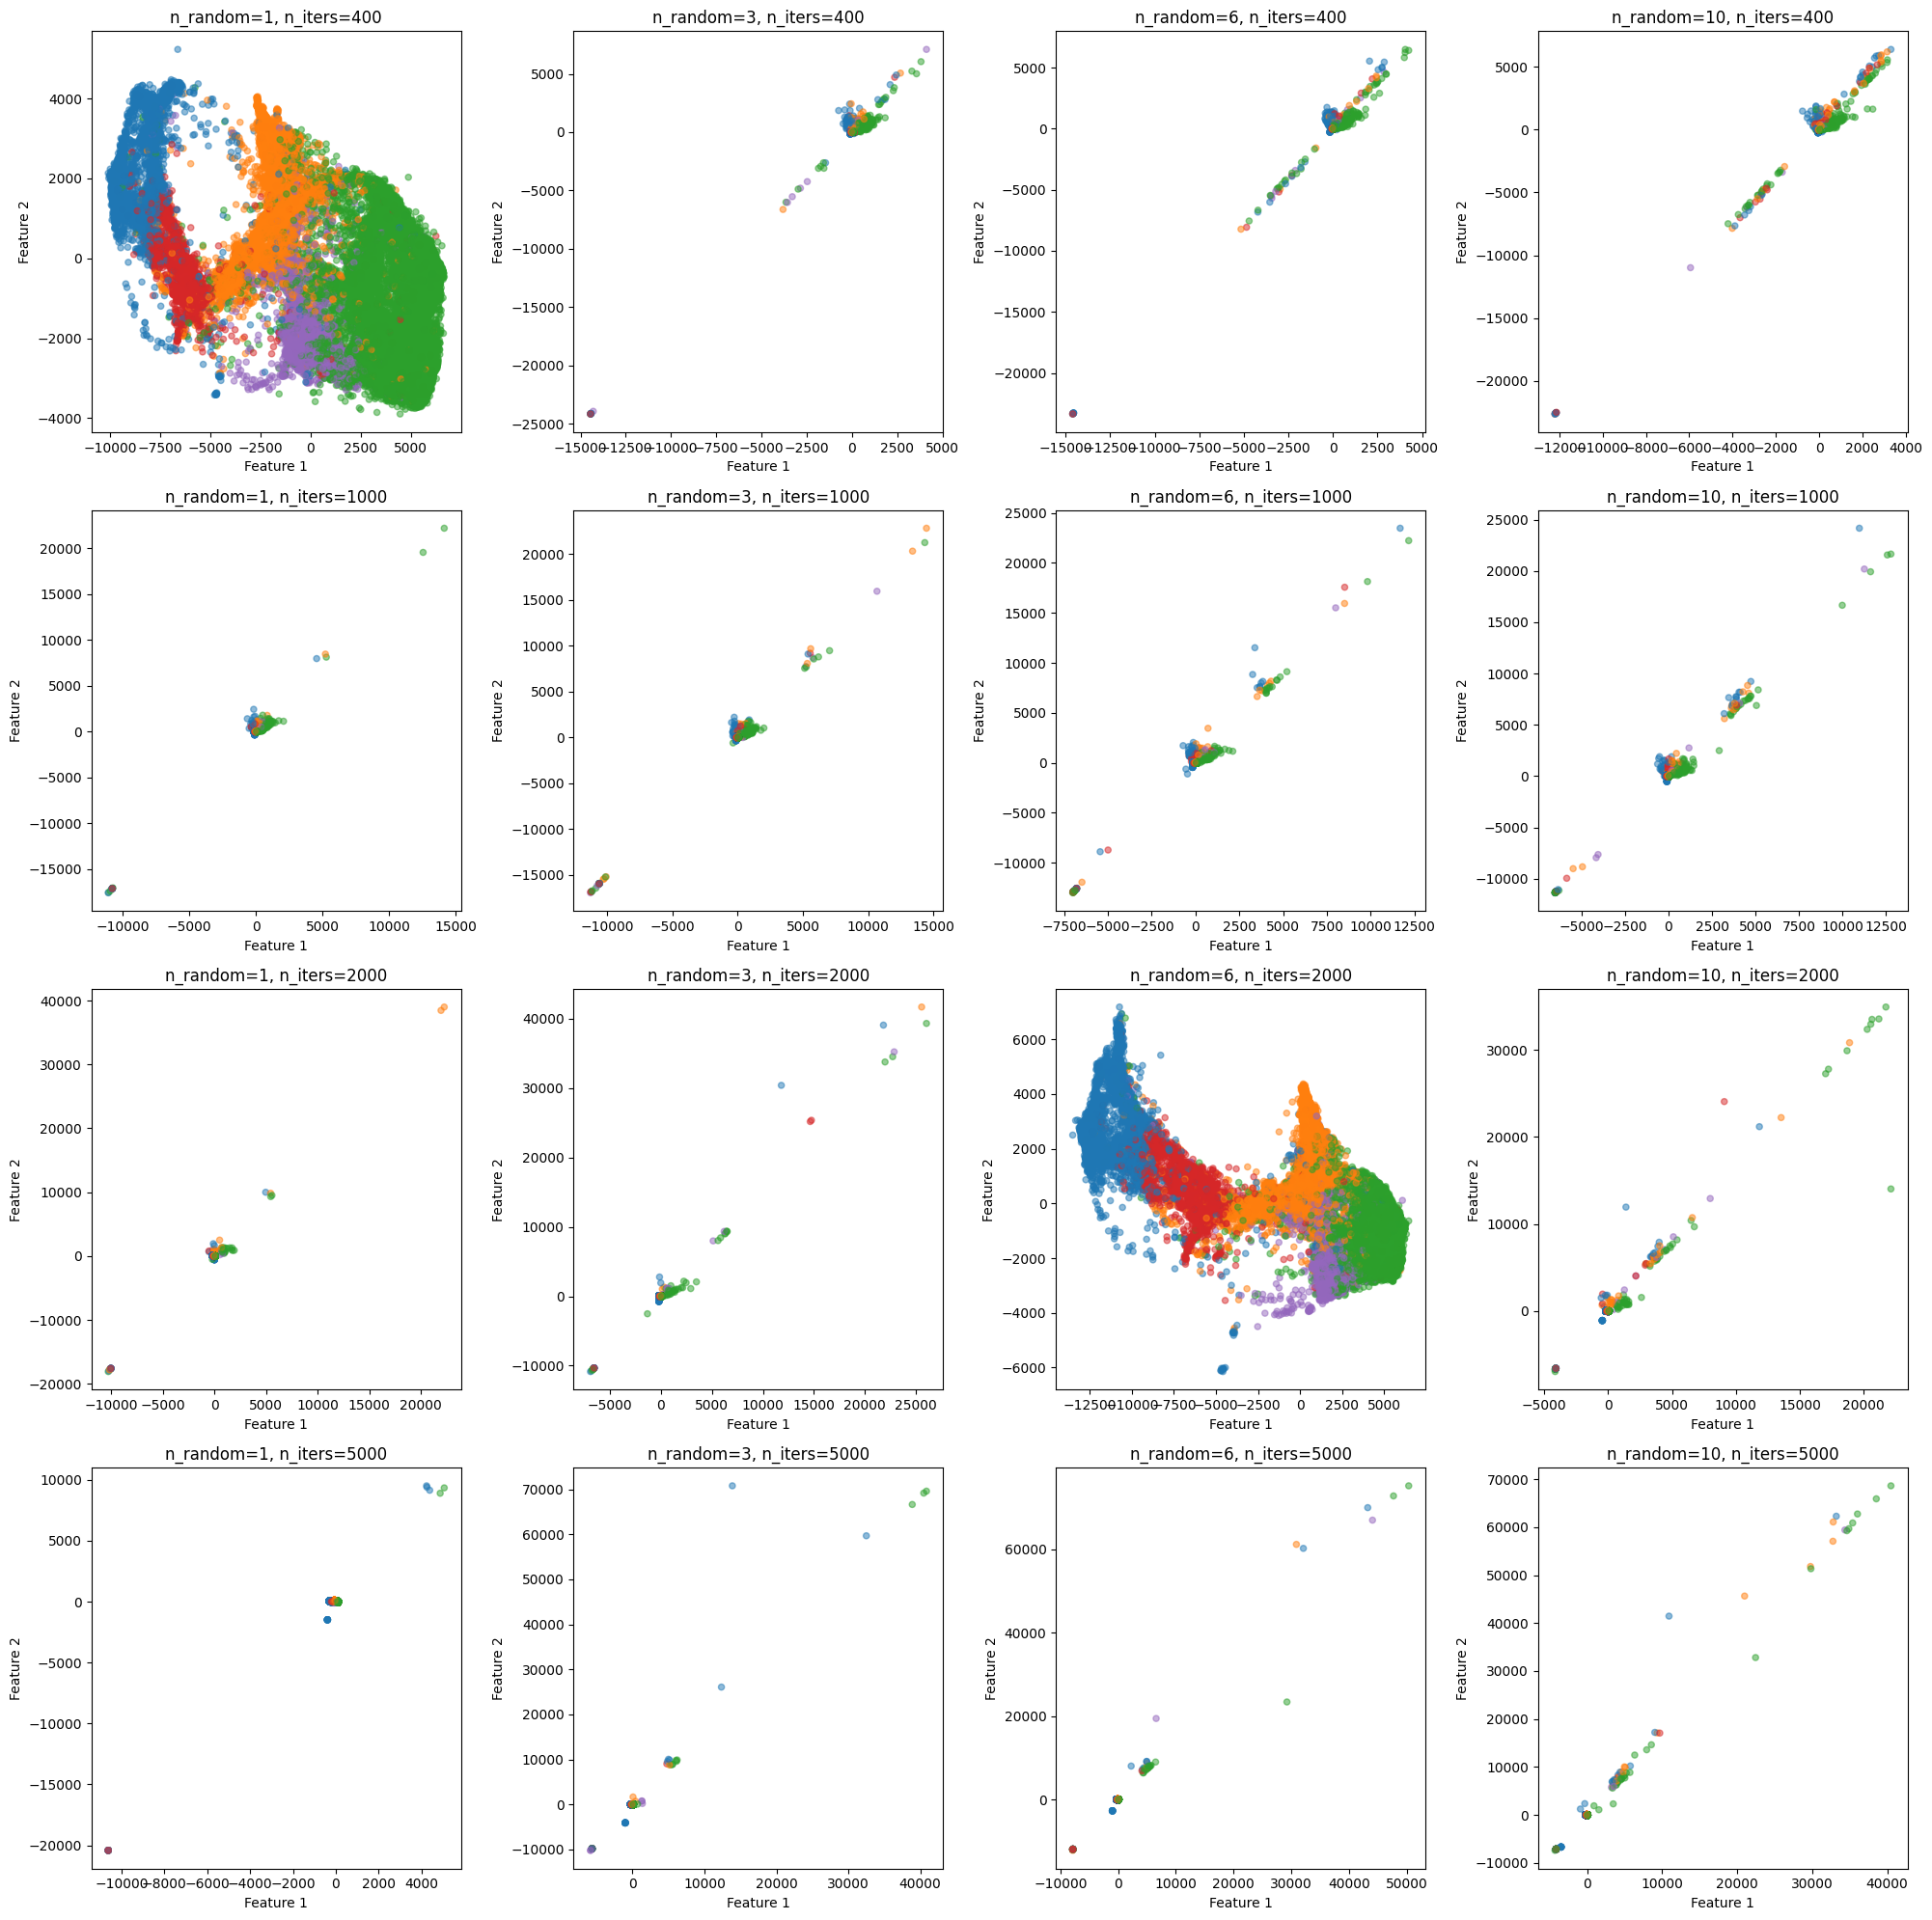

In [12]:
distance='cosine'
n_inliers=6
n_outliers=2


fig, axs = plt.subplots(4, 4, figsize=(20, 20))
axs = axs.flatten()
i = 0
for n_iters in [400, 1000, 2000, 5000]:
    for n_random in [1, 3, 6, 10]:
        umap_post = TRIMAP(n_dims=2 , n_random=n_random, n_iters=n_iters, distance=distance)
        umap_results = umap_post.fit_transform(data_x_cpu)

        plot_no_show(axs[i], umap_results, data_y_cpu, f'n_random={n_random}, n_iters={n_iters}', size=20)

        i += 1


plt.tight_layout()
plt.show()

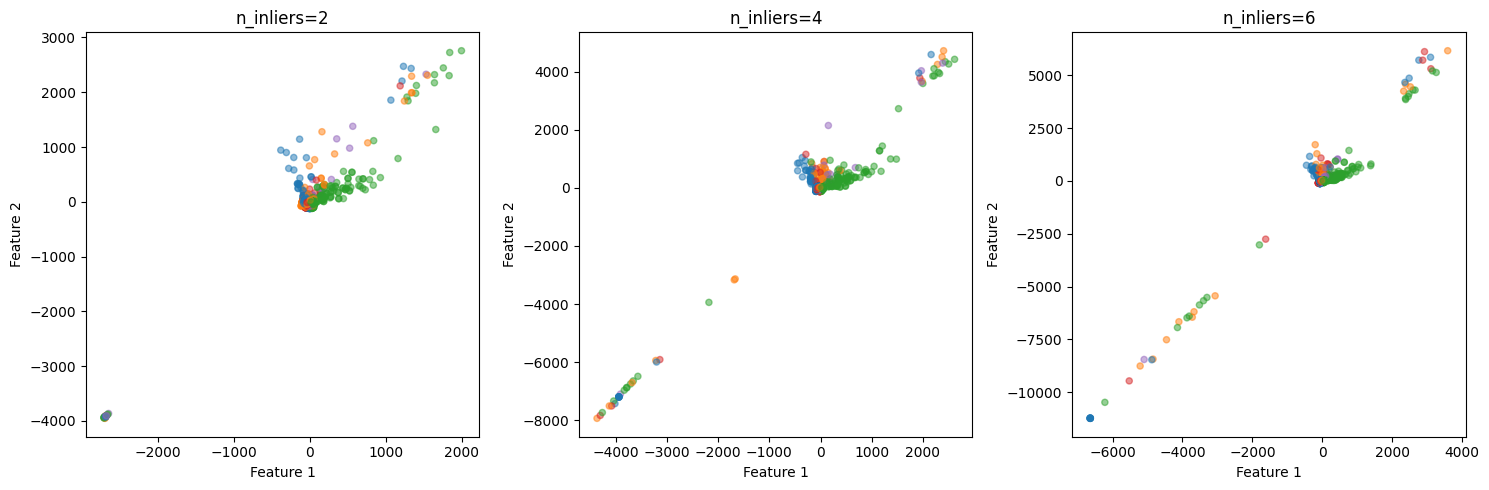

In [13]:
distance='cosine'
n_inliers=6
n_outliers=2


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()
i = 0
for n_inliers in [2, 4, 6]:
    umap_post = TRIMAP(n_dims=2 , n_inliers=n_inliers, distance=distance)
    umap_results = umap_post.fit_transform(data_x_cpu)

    plot_no_show(axs[i], umap_results, data_y_cpu, f'n_inliers={n_inliers}', size=20)

    i += 1


plt.tight_layout()
plt.show()

### 4.3 Fine-tuned TRIMAP vs default TRIMAP

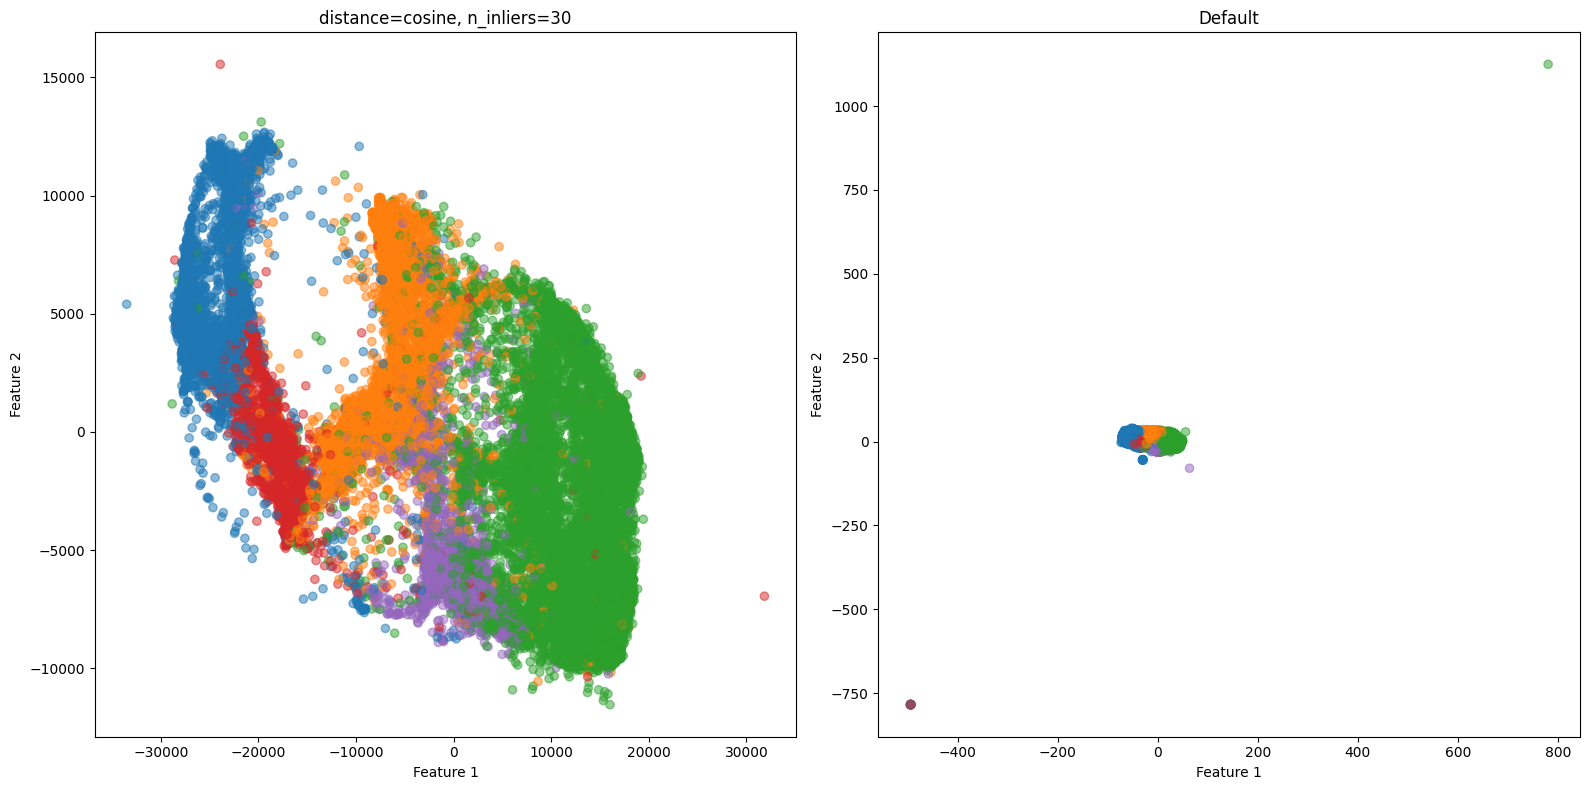

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

distance='cosine'
n_inliers=30


umap_post = TRIMAP(n_dims=2, n_inliers=n_inliers, distance=distance)
umap_results = umap_post.fit_transform(data_x_cpu)

plot_no_show(axs[0], umap_results, data_y_cpu, f'distance={distance}, n_inliers={n_inliers}')

umap_post = TRIMAP(n_dims=2)
umap_results = umap_post.fit_transform(data_x_cpu)

plot_no_show(axs[1], umap_results, data_y_cpu, f'Default')

plt.tight_layout()
plt.show()

## 5. TRIMAP on original features vs learned representations

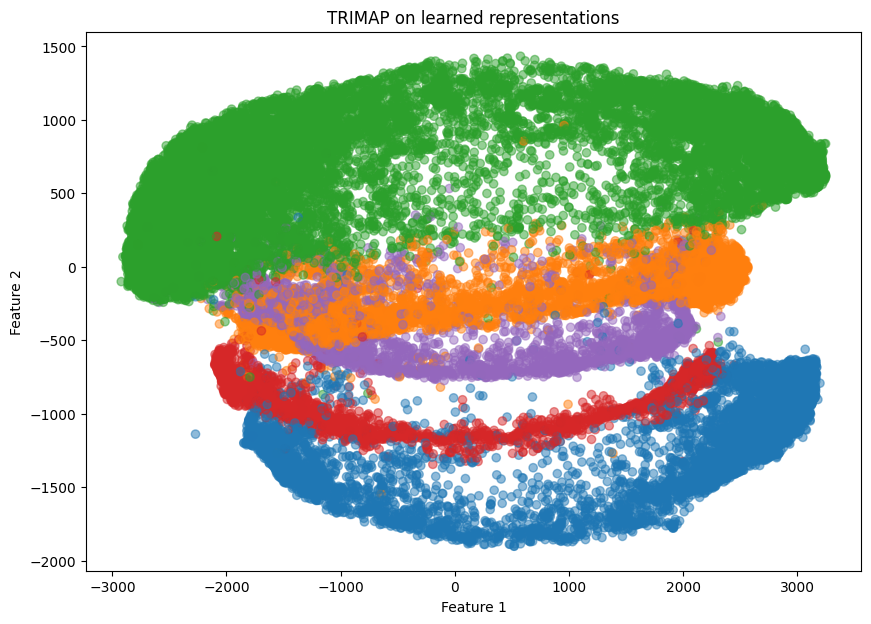

In [16]:
distance='cosine'
n_inliers=30

umap_post = TRIMAP(n_dims=2, distance=distance)
umap_results = umap_post.fit_transform(embeddings)

visualise(umap_results, data_y_cpu, f'TRIMAP on learned representations')


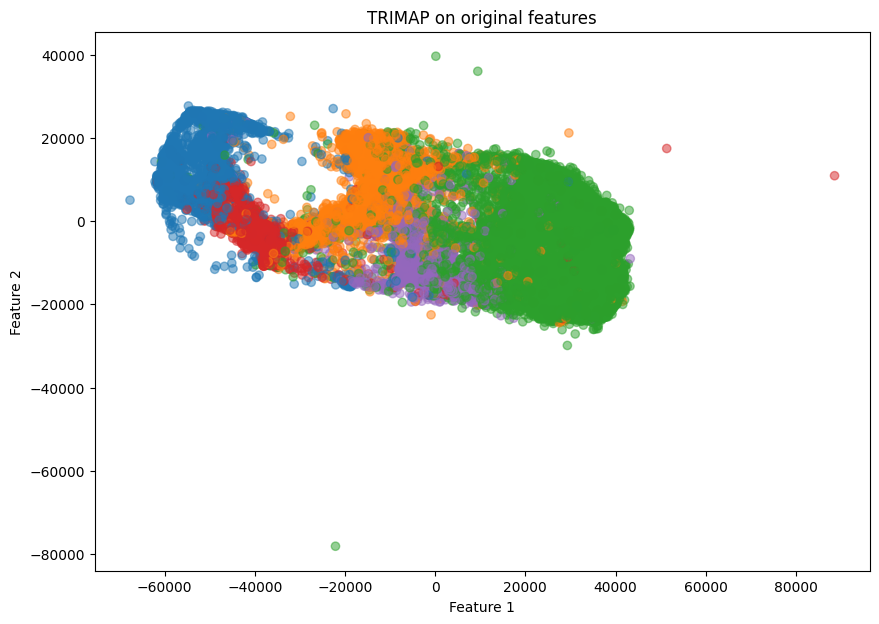

In [13]:
distance='cosine'
n_inliers=30

umap_post = TRIMAP(n_dims=2, n_inliers=n_inliers, distance=distance)
umap_results = umap_post.fit_transform(data_x_cpu)

visualise(umap_results, data_y_cpu, f'TRIMAP on original features')

## 6. Final conclusions
**TRIMAP AS POSTPROCESSING STEP**

**Left plot: TRIMAP on original features**
- Feature overlap: There is a notable overlap among different classes, as indicated by the mingling of colors. This suggests that the original high-dimensional space does not easily allow for class separation.
- Global structure: TRIMAP has a tendency to maintain more of the global structure of the data compared to t-SNE, and this plot does show some broad groupings. However, the boundaries are not well-defined, which could imply that the original features alone may not be optimal for tasks that rely on clear class discrimination.


**Right plot: TRIMAP on learned representations**
- Improved clustering: The plot representing TRIMAP on the GNN's learned representations exhibits better clustering of similar data points (nodes). The colors representing different classes are more segregated into distinct clusters than in the original feature space.
- Class separation: The separation between clusters indicates that the GNN model is producing embeddings that encapsulate the structural and feature-related properties of the graph more effectively than the original features alone.
- Data manifold: The shape of the data distribution suggests that TRIMAP has captured a complex manifold where the GNN's learned representations reside. It indicates that the GNN has learned embeddings that reflect underlying data patterns conducive to node classification.


**TRIMAP AS PREPROCESSING STEP**
- TRIMAP applied as preprocessing step proved to be very fragile to fine-tuning.
- Default TRIMAP configuration performed very poorly, not exceeding 0.3 accuracy or other distances values.
- Fine-tuned TRIMAP performed much better although the distances still fell down by 5%.